In this iPython notebook, we will featurize MOR ligand binding simulation by pairwise distances between the ligand and different receptor residues. We will then perform tICA and prospectively build an MSM. 

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# changing matplotlib the default style
matplotlib.style.use('ggplot')

from PDB_Order_Fixer import PDB_Order_Fixer
import mdtraj as md
import os
import numpy as np
import h5py

import datetime
import glob
import copy
from functools import partial 
import operator
import time

import random 
import subprocess
from subprocess import Popen
import sys
from io_functions import *
from custom_clusterer import *
from custom_tica import *
from custom_featurizer import *
from pdb_editing import *
from analysis import *
from io_functions import *
#from topology_fixing import *
from subsampling import *
from conversions import *
from custom_msm import *
from grids import *
from docking_analysis import *

Couldn't import dot_parser, loading of dot files will not be possible.


/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
%matplotlib inline

In [3]:
from detect_intermediates import *
from interpret_tICs import *

we are operating on biox3


In [4]:
from mor_h8_protein_ligand_feature_types import *
from get_variable_names import *
from mor_h8_protein_ligand_tica_config import *
from residue import Residue, Atom
from mor_h8_feature_types import feature_name_residues_dict


[65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284,

In [5]:
#feature_name = "bp_residues_4dkl_5c1m_restricted_pairs"
rho = 0.05
rho_string = "_rho0pt05-normalized"

feature_name = "bp_residues_4dkl_5c1m_restricted_pairs_10A"
#rho = 0.0025
#rho_string = "_rho0pt0025-normalized"

lag_time=50
n_clusters=1000
n_components=10

In [6]:
feature_name

'bp_residues_4dkl_5c1m_restricted_pairs_10A'

In [7]:
(active_ref_dir, inactive_ref_dir, simulation_ref_dir, scripts_dir,
          ligand_dir, agonist_dir, inverse_agonist_dir, biased_agonist_dir, ref_receptors_dir, whole_trajectory_pnas,
          sasa_file) = get_base_files(base)

tica_dir = get_tica_dir(base, is_sparse, lag_time, n_components, feature_name, 
                                 wolf_string, shrinkage_string, rho_string)
ori_tica_dir = copy.deepcopy(tica_dir)
features_dir = get_features_dir(base, feature_name)

landmarks_dir = get_landmarks_dir(tica_dir)
analysis_dir = get_analysis_dir(tica_dir, n_clusters, sampling_method)
gmm_dir = get_gmm_dir(tica_dir)
rf_dir = get_rf_dir(tica_dir)


ref_tica_dir, ref_tica_coords = get_ref_tica_dirs(tica_dir)

graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)

pnas_titles =  ["tm6_tm3_dist", "rmsd_npxxy_inactive", "rmsd_npxxy_active", "rmsd_connector_inactive", "rmsd_connector_active"]
pnas_features_dir = analysis_dir


(clusterer_dir, msm_model_dir, macrostate_dir, features_known, model_dir, projected_features_dir,
         projection_operator_dir, ktica_fit_model_filename, ktica_projected_data_filename, nystroem_data_filename,
         mutual_information_csv, pearson_csv) = get_tica_files(base, tica_dir, n_clusters, msm_lag_time, n_macrostates)

(standardized_features_dir, feature_residues_csv, feature_residues_pkl,
          contact_csv, ref_features_dir) = get_feature_files(features_dir)

(kmeans_csv, tica_coords_csv, features_csv, active_rmsd_dir, inactive_rmsd_dir, active_pnas_dir, inactive_pnas_joined, active_pnas_joined,
        clusters_map_file, ktica_clusters_map_file, analysis_file, combined_file, docking_summary, docking_joined, docking_z_scores_csv,
        aggregate_docking, aggregate_docking_joined, docking_pnas_joined, aggregate_docking_pnas, aggregate_docking_pnas_joined, docking_multiple_ligands,
        docking_distances_file, docking_pdf, mmgbsa_docking_distances, pnas_coords, mmgbsa_dir, mmgbsa_csv, mmgbsa_pdf, aggregate_mmgbsa,
        aggregate_mmgbsa_joined, aggregate_mmgbsa_pnas_joined, mmgbsa_z_scores_csv, active_clusters_csv, intermediate_clusters_csv,
        inactive_clusters_csv, pnas_clusters_averages, tica_clusters_averages, tica_classes_csv, tica_samples_csv, subgraph_save_base,
        degree_save_base, degree_map_csv, degree_z_map_csv, aggregate_docking_pnas_degree_z_joined, tic_residue_csv, feature_coefs_csv,
        duplicated_feature_coefs_csv) = get_analysis_files(analysis_dir, n_clusters, tica_dir, tica_dir, sampling_method, n_samples, precision,
                                                           msm_lag_time)

(inactive_pnas_distances_dir, active_pnas_distances_dir, active_pnas_all_distances_dir,
          inactive_pnas_distances_new_csv, active_pnas_distances_new_csv, active_pnas_joined, active_pnas_means, pnas_coords_dir,
          pnas_coords_csv, pnas_all_coords_csv, pnas_coords_hexbin_dir, pnas_coords_co_crystallized_docking_dir,
          pnas_coords_active_colors_dir, user_defined_features_file, reaction_coordinates_trajs_file) = get_pnas_files(whole_trajectory_pnas, pnas_features_dir)

features_dir = get_features_dir(base, feature_name)



graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)
(scripts_dir, pymol_fixpdb_dir) = get_script_dir(scripts_dir)
(save_dir, reimaged_dir, mae_dir, combined_reimaged_dir, grid_dir, docking_dir) = get_docking_dirs(tica_dir, n_clusters, n_components, n_samples, sampling_method, precision)


/home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A
/home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A


In [8]:
ligand_residue = Residue(resSeq=900, chain_id="L", res_name="LIG")

In [9]:
active_crystal = md.load_frame([t for t in get_trajectory_files(traj_dir, traj_ext) if "suf" in t][0], index=0)
ligand = [r for r in active_crystal.topology.residues if "LIG" in str(r)][0]
ligand_atom_names = [a.name for a in ligand.atoms if "H" not in a.name]
print(ligand_atom_names)

[u'C6', u'C7', u'C8', u'C9', u'C10', u'C11', u'C23', u'C24', u'C25', u'C26', u'C27', u'C28', u'C1', u'C2', u'N1', u'C3', u'C4', u'C5', u'O1', u'C12', u'C13', u'N2', u'C14', u'O2', u'C15', u'C16', u'C17', u'C18', u'C19', u'C20', u'C21', u'C22']


In [10]:
#ligand_atom_names = ["N1", "O1", "C7", "C17", "O2", "N2", "C26"]
ligand_atoms = []
for atom_name in ligand_atom_names:
    ligand_atoms.append(Atom(resSeq=900, chain_id="L", atom_name=atom_name, res_name="LIG"))

In [11]:
user_specified_atom_residue_pairs = [x for x in itertools.product(ligand_atoms, bp_residue_objects)]
user_specified_atom_residue_pairs = [ContactFeature(pair[0], pair[1]) for pair in user_specified_atom_residue_pairs]

In [12]:
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
protein_file = "/home/enf/md_simulations/MOR/mor_active_suf_h8/ionized.pdb"
refined_atom_residue_pairs = compute_atom_residue_pairs_under_cutoff(ligand_atoms, bp_residue_objects, protein_file, cutoff=1., all_lig_atoms=True)

In [13]:
refined_atom_residue_pairs

[(LIG-C6, TRP318),
 (LIG-C6, CYS321),
 (LIG-C6, ILE322),
 (LIG-C6, ALA323),
 (LIG-C6, LEU324),
 (LIG-C6, GLY325),
 (LIG-C6, TYR326),
 (LIG-C6, ILE198),
 (LIG-C6, LEU219),
 (LIG-C6, LEU232),
 (LIG-C6, LYS233),
 (LIG-C6, VAL236),
 (LIG-C6, PHE237),
 (LIG-C6, ALA240),
 (LIG-C6, PHE241),
 (LIG-C6, CYS292),
 (LIG-C6, TRP293),
 (LIG-C6, THR294),
 (LIG-C6, PRO295),
 (LIG-C6, ILE296),
 (LIG-C6, HIS297),
 (LIG-C6, ILE298),
 (LIG-C6, TYR299),
 (LIG-C6, VAL300),
 (LIG-C6, ILE301),
 (LIG-C6, TYR148),
 (LIG-C6, ASN150),
 (LIG-C6, MET151),
 (LIG-C6, PHE152),
 (LIG-C6, ILE155),
 (LIG-C6, ILE144),
 (LIG-C6, ASP147),
 (LIG-C6, THR120),
 (LIG-C6, GLN124),
 (LIG-C7, TRP318),
 (LIG-C7, CYS321),
 (LIG-C7, ILE322),
 (LIG-C7, ALA323),
 (LIG-C7, LEU324),
 (LIG-C7, GLY325),
 (LIG-C7, TYR326),
 (LIG-C7, ILE198),
 (LIG-C7, LEU232),
 (LIG-C7, LYS233),
 (LIG-C7, ILE234),
 (LIG-C7, CYS235),
 (LIG-C7, VAL236),
 (LIG-C7, PHE237),
 (LIG-C7, ILE238),
 (LIG-C7, PHE239),
 (LIG-C7, ALA240),
 (LIG-C7, PHE241),
 (LIG-C7, CY

In [13]:
refined_atom_residue_pairs = [ContactFeature(pair[0], pair[1]) for pair in refined_atom_residue_pairs]
print(len(refined_atom_residue_pairs))


1023


In [75]:
from ipyparallel import Client
rc = Client()
print(len(rc.ids))
dview = rc[:]
dview.map(os.chdir, ['/home/enf/b2ar_analysis/conformation']*len(rc.ids))

228


<AsyncMapResult: chdir>

In [ ]:
len(refined_atom_residue_pairs)

In [ ]:
if not os.path.exists(features_dir): os.makedirs(features_dir)
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
import time
#time.sleep(60*120)
featurize_contacts_custom(traj_dir, features_dir = features_dir, traj_ext = traj_ext, contact_residue_pairs_file = feature_residues_pkl, structures=[], contact_residues=[],
                          residues_map = None, contact_cutoff = cutoff, parallel = False, exacycle = exacycle, traj_top_structure = None, iterative=False,
                          user_specified_atom_residue_pairs=refined_atom_residue_pairs, worker_pool=None, excluded_trajs=["apo", "oxy", "suf"])

In [14]:
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
new_features_dir = "%s/reduced_features" %features_dir
if not os.path.exists(new_features_dir):
    os.makedirs(new_features_dir)
new_features_file = "%s/reduced_features.dataset" %new_features_dir
new_features_pkl = "%s/reduced_feature_names.pkl" %new_features_dir
#retain_features_within_range(features_dir, feature_residues_pkl, 0.5,
#                             0.1, new_features_file, new_features_pkl, worker_pool=dview)

In [15]:
with open(new_features_pkl) as f:
    new_feature_names = pickle.load(f)
    feature_residues = new_feature_names
print(new_feature_names)
print(len(new_feature_names))

[Lig900-C6 to Gly325, Lig900-C6 to Met151, Lig900-C6 to Trp293, Lig900-C6 to Ile296, Lig900-C7 to Gly325, Lig900-C7 to Met151, Lig900-C7 to Val236, Lig900-C7 to Trp293, Lig900-C7 to Ile296, Lig900-C7 to His297, Lig900-C7 to Val300, Lig900-C8 to Gly325, Lig900-C8 to Met151, Lig900-C8 to Val236, Lig900-C8 to Trp293, Lig900-C8 to Ile296, Lig900-C8 to His297, Lig900-C8 to Val300, Lig900-C9 to Met151, Lig900-C9 to Tyr148, Lig900-C9 to Lys233, Lig900-C9 to Val236, Lig900-C9 to Trp293, Lig900-C9 to Ile296, Lig900-C9 to His297, Lig900-C9 to Val300, Lig900-C10 to Met151, Lig900-C10 to Tyr148, Lig900-C10 to Val236, Lig900-C10 to Ile296, Lig900-C10 to His297, Lig900-C10 to Val300, Lig900-C11 to Met151, Lig900-C11 to Tyr148, Lig900-C11 to Ile296, Lig900-C23 to Ile144, Lig900-C23 to Asp147, Lig900-C23 to Gln124, Lig900-C24 to Cys217, Lig900-C24 to Trp318, Lig900-C24 to Ile144, Lig900-C24 to Gln124, Lig900-C25 to Cys217, Lig900-C25 to Thr218, Lig900-C25 to Leu219, Lig900-C25 to Trp318, Lig900-C25 to

In [16]:
ref_receptors_dir = "/home/enf/md_simulations/MOR/suf_ref_receptors" 
ref_features_dir = "%s/suf_ref_receptors" %features_dir
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
featurize_contacts_custom(ref_receptors_dir, features_dir = ref_features_dir, traj_ext = ".pdb", contact_residue_pairs_file = feature_residues_pkl, structures=[], contact_residues=[],
                          residues_map = None, contact_cutoff = cutoff, parallel = False, exacycle = exacycle, traj_top_structure = None, iterative=False,
                          user_specified_atom_residue_pairs = new_feature_names, worker_pool=None, schemes=[])

already featurized
already featurized


UnboundLocalError: local variable 'structure_contact_residue_pairs' referenced before assignment

In [17]:
import pickle
with open(new_features_pkl, "rb") as f:
    feature_residues = pickle.load(f)

In [18]:
feature_residues[:10]

[Lig900-C6 to Gly325,
 Lig900-C6 to Met151,
 Lig900-C6 to Trp293,
 Lig900-C6 to Ile296,
 Lig900-C7 to Gly325,
 Lig900-C7 to Met151,
 Lig900-C7 to Val236,
 Lig900-C7 to Trp293,
 Lig900-C7 to Ile296,
 Lig900-C7 to His297]

In [ ]:
#os.system("rm -rf %s" % tica_dir)
#lag_time = 5
#n_components = 5
#sparse = True
#wolf = True
#rho = 0.0025
#shrinkage = None
#traj_ext = ".h5"
import custom_tica
reload(custom_tica)
from custom_tica import *
#fit_normalizer(features_dir, features=load_file(new_features_file))
fit_and_transform(features_directory = features_dir, model_dir = tica_dir, stride=5, lag_time = lag_time, n_components = n_components, sparse = sparse, wolf = wolf, rho = rho, shrinkage = shrinkage, parallel=True, traj_ext = traj_ext, normalize=True, partial_fit=False, features=load_file(new_features_file))

In [20]:
import custom_tica
reload(custom_tica)
from custom_tica import *
if not os.path.exists(ref_features_dir):
    os.makedirs(ref_features_dir)
transform(existing_model = projection_operator_dir, features_directory = ref_features_dir, tica_dir = ref_tica_dir, normalizer=verboseload("%s/normalizer.h5" %features_dir))

loading "/home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A/normalizer.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-normalized/phi_psi_chi2_allprot_tica_coords.h5"...
None
None
['/home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A/bu72_ref_receptors/bu72_aligned_4DKL_R_L.dataset', '/home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A/bu72_ref_receptors/bu72_ionized_pymol_RL.dataset']
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A/bu72_ref_receptors/bu72_aligned_4DKL_R_L.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A/bu72_ref_receptors/bu72_ionized_pymol_RL.dataset


In [19]:
tica_object = verboseload(projection_operator_dir)
tica_object.timescales_

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-normalized/phi_psi_chi2_allprot_tica_coords.h5"...


array([ 495.01387945,  481.81564338,  392.08565491,  304.86356991,
        197.00075377,  153.93370155,  122.62525211,  108.47723675,
         93.23733288,   84.72655529])

In [20]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *
tic_components_dir = tica_dir
important_contact_features, all_tIC_features = interpret_tIC_components(projection_operator_dir, tic_components_dir, new_features_pkl, n_tica_components=n_components, percentile=95)

Interpreting tIC 1
feature_importances_df.shape
(3, 7)
residue_importances_df.shape
(5, 3)
          feature_name      res_i   res_j  resid_i  resid_j  importance  \
1  Lig900-O1 To Trp293  Lig900-O1  Trp293      900      293    0.731784   
2  Lig900-O2 To Cys321  Lig900-O2  Cys321      900      321    0.495822   
0  Lig900-C6 To Trp293  Lig900-C6  Trp293      900      293   -0.495320   

               feature  
1  Lig900-O1 to Trp293  
2  Lig900-O2 to Cys321  
0  Lig900-C6 to Trp293  
Using dark_background
             residue  importance  resid
Lig900-O1  Lig900-O1    0.731784    900
Trp293        Trp293    0.670429    293
Cys321        Cys321    0.495822    321
Lig900-O2  Lig900-O2    0.495822    900
Lig900-C6  Lig900-C6   -0.495320    900
Using dark_background
Interpreting tIC 2
feature_importances_df.shape
(4, 7)
residue_importances_df.shape
(6, 3)
           feature_name       res_i   res_j  resid_i  resid_j  importance  \
1  Lig900-C25 To Trp133  Lig900-C25  Trp133      900    

In [21]:
tic_subsampled_features_file= "%s/features_subsampled.pkl" % tica_dir



In [22]:
len(feature_residues)

158

In [23]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *

print tic_subsampled_features_file
subsampled_features_dir = os.path.join(tica_dir, "subsampled_features")
if not os.path.exists(subsampled_features_dir): os.makedirs(subsampled_features_dir)
important_contact_features_pruned, important_contact_features_indices = find_non_zero_features(important_contact_features, feature_residues)
#subsample_features(features_dir, important_contact_features_indices, important_contact_features_pruned, tic_subsampled_features_file, features=load_file(new_features_file))

/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-normalized/features_subsampled.pkl


In [24]:
tica_coords = verboseload(projected_features_dir)
print(np.shape(np.concatenate(tica_coords)))

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-normalized/phi_psi_chi2_allprot_projected.h5"...
(248499, 10)


In [ ]:
import analysis
reload(analysis)
from analysis import *
plot_columns(tica_dir, projected_features_dir, titles = ["suf_tIC%d" %j for j in range(1,11)], tICA = True, scale = 1.0, refcoords_file = None)

In [25]:
suf_trajs = []
apo_trajs = []
#trajs = [t for t in get_trajectory_files(traj_dir, traj_ext) if "apo_reimaged" not in t and "oxy" not in t]
trajs = [t for t in get_trajectory_files(traj_dir, traj_ext)]
for i, traj in enumerate(trajs):
    if "suf" in traj:
        suf_trajs.append(i)
    elif "apo" in traj:
        apo_trajs.append(i)

user_defined_coords = load_file(user_defined_features_file)

            

loading /home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/user_defined_features.h5
loading "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/user_defined_features.h5"...


In [26]:
#pp_tica_dir = "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components5all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt0025"
pp_tica_dir = "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01"

In [27]:
protein_tica_file = "%s/phi_psi_chi2_allprot_projected.h5" %pp_tica_dir
protein_tica = verboseload(protein_tica_file)
protein_tica_suf = [protein_tica[i] for i in suf_trajs]

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01/phi_psi_chi2_allprot_projected.h5"...


In [28]:
len(suf_trajs)

512

In [29]:
protein_tica_suf_conc = np.concatenate(protein_tica_suf)
ligand_tica_suf_conc =  np.concatenate(verboseload(projected_features_dir))

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-normalized/phi_psi_chi2_allprot_projected.h5"...


In [30]:
import plots
reload(plots)
from plots import *

#plot_data_vs_data(protein_tica_suf_conc, ligand_tica_suf_conc, ["mOR_tIC%d" %i for i in range(1,n_components+1)], ["suf_tIC%d" %i for i in range(1,n_components+1)], analysis_dir)

In [31]:
n_clusters = 1000
clusterer_dir = "%s/sufclusterer_%dclusters.h5" % (tica_dir, n_clusters)
#cluster_minikmeans(tica_dir, projected_features_dir, traj_dir, n_clusters, clusterer_dir)

In [35]:
import custom_msm
reload(custom_msm)
from custom_msm import *
plot_timescales(clusterer_dir, n_clusters, tica_dir, main="", lag_times=list(range(1,51,10)))

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-normalized/bu72clusterer_1000clusters.h5"...


IOError: Unable to load /home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-normalized/bu72clusterer_1000clusters.h5 using the pickle or joblib protocol.
Pickle: [Errno 2] No such file or directory: '/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-normalized/bu72clusterer_1000clusters.h5'
Joblib: [Errno 2] No such file or directory: '/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-normalized/bu72clusterer_1000clusters.h5'

In [ ]:
lag_time = 30
msm_model_dir = "%s/msm_lag_time%d.h5" % (tica_dir, lag_time)
if not os.path.exists(msm_model_dir):
    build_msm(clusterer_dir, lag_time=lag_time, msm_model_dir=msm_model_dir)

In [32]:
import msmbuilder 
reload(msmbuilder)
import msm_resampled
reload(msm_resampled)
from msm_resampled import *

In [33]:
'%s/suf_clusterer1000.h5' %pp_tica_dir

'/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01/bu72_clusterer1000.h5'

In [34]:
pp_msm_lag_time=50
suf_pp_resampled_traj_to_frames_file = "%s/suf_msm_lag-time%d_prior-counts0.0_clusters1000_resampled_10000.h5" %(pp_tica_dir, pp_msm_lag_time)
suf_pp_resampled_traj_to_frames = verboseload(suf_pp_resampled_traj_to_frames_file)
suf_pp_msm_file = "%s/suf_msm_lag-time%d_prior-counts0.0_clusters1000.h5" %(pp_tica_dir, pp_msm_lag_time)
suf_pp_msm = verboseload(suf_pp_msm_file)
suf_pp_clusterer = verboseload('%s/suf_clusterer1000.h5' %pp_tica_dir)
suf_pp_clusters_map = make_clusters_map(suf_pp_clusterer)
suf_pp_projection_operator_dir = "%s/phi_psi_chi2_allprot_tica_coords.h5" %pp_tica_dir
suf_pp_tic_components_dir = "%s" %pp_tica_dir
suf_pp_tica_dir = suf_pp_tic_components_dir
suf_pp_feature_residues_pkl = "/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/feature_residues.pkl"
pp_tic_subsampled_features = "%s/features_subsampled.pkl" %pp_tica_dir
suf_pp_tica = verboseload("%s/suf_tica_msm_lag-time%d_prior-counts0.0_clusters1000_resampled_10000.h5" %(pp_tica_dir, pp_msm_lag_time))
suf_pp_pnas_file = "%s/suf_pnas_msm_lag-time%d_prior-counts0.0_clusters1000_resampled_10000.h5" %(pp_tica_dir, pp_msm_lag_time)
suf_pp_pnas = verboseload(suf_pp_pnas_file)
suf_pp_ref_tica = "%s/reference_receptors/refcoords.csv" %pp_tica_dir
suf_pp_ref_features_dir = '/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/reference_receptors'

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01/bu72_msm_lag-time50_prior-counts0.0_clusters1000_resampled_10000.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01/bu72_msm_lag-time50_prior-counts0.0_clusters1000.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01/bu72_clusterer1000.h5"...
34
2109
0
285
1
76
400
155
0
0
307
679
0
19
1600
0
0
508
0
489
93
0
719
2
1
2
38
19
0
10
1123
0
2224
24
292
87
127
77
382
1202
0
1755
209
300
0
26
509
0
55
0
0
2
88
4
106
50
0
0
1
4
114
55
2336
1
24
0
0
0
105
73
0
863
0
3
836
281
595
0
0
29
697
45
183
51
467
141
1554
49
861
0
0
29
340
585
0
179
14
181
774
3
996
888
0
236
1241
101
0
17
14
404
0
86
312
377
9
467
184

In [35]:
pp_msm_lag_time=50
apo_pp_resampled_traj_to_frames_file = "%s/apo_msm_lag-time%d_prior-counts0.0_clusters1000_resampled_10000.h5" %(pp_tica_dir, pp_msm_lag_time)
apo_pp_resampled_traj_to_frames = verboseload(apo_pp_resampled_traj_to_frames_file)
apo_pp_msm_file = "%s/apo_msm_lag-time%d_prior-counts0.0_clusters1000.h5" %(pp_tica_dir, pp_msm_lag_time)
apo_pp_msm = verboseload(apo_pp_msm_file)
apo_pp_clusterer = verboseload('%s/apo_clusterer1000.h5' %pp_tica_dir)
apo_pp_clusters_map = make_clusters_map(apo_pp_clusterer)
apo_pp_projection_operator_dir = "%s/phi_psi_chi2_allprot_tica_coords.h5" %pp_tica_dir
apo_pp_tic_components_dir = "%s" %pp_tica_dir
apo_pp_tica_dir = apo_pp_tic_components_dir
apo_pp_feature_residues_pkl = "/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/feature_residues.pkl"
apo_pp_tic_subsampled_features = "%s/features_subsampled.pkl" %pp_tica_dir
apo_pp_tica = verboseload("%s/apo_tica_msm_lag-time%d_prior-counts0.0_clusters1000_resampled_10000.h5" %(pp_tica_dir, pp_msm_lag_time))
apo_pp_pnas_file = "%s/apo_pnas_msm_lag-time%d_prior-counts0.0_clusters1000_resampled_10000.h5" %(pp_tica_dir, pp_msm_lag_time)
apo_pp_pnas = verboseload(apo_pp_pnas_file)
apo_pp_ref_tica = "%s/reference_receptors/refcoords.csv" %pp_tica_dir
apo_pp_ref_features_dir = '/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/reference_receptors'

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01/apo_msm_lag-time50_prior-counts0.0_clusters1000_resampled_10000.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01/apo_msm_lag-time50_prior-counts0.0_clusters1000.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01/apo_clusterer1000.h5"...
89
2040
0
0
79
3
0
20
1
211
191
974
503
133
660
0
0
851
90
0
37
579
0
8
163
3
38
340
0
91
721
0
1256
29
122
7
403
159
0
2124
155
82
0
0
0
217
897
80
3
8
150
66
47
111
128
84
406
40
14
136
8
402
1265
293
0
259
10
0
271
37
205
2
141
0
531
0
119
112
199
159
465
19
257
71
0
0
216
1012
377
495
227
66
191
444
0
7
108
0
1
160
378
673
59
50
768
487
79
216
349
47
374
601
0
79

In [36]:
pp_n_components=10
def get_features(features_dir):
    feature_files = get_trajectory_files(features_dir, ".dataset")
    features = np.vstack([load_file(f) for f in feature_files])
    print(features.shape)
    return features

pp_feature_residues_pkl = "/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/feature_residues.pkl"
with open(pp_feature_residues_pkl) as f:
    pp_feature_residues = pickle.load(f)
with open(new_features_pkl) as f:
    lp_feature_residues = pickle.load(f)

ref_pp_features = pd.DataFrame(get_features(suf_pp_ref_features_dir), columns=[str(f) for f in pp_feature_residues])
ref_lp_features = pd.DataFrame(get_features(ref_features_dir), columns=[str(f) for f in lp_feature_residues])
ref_pp_tica = pd.read_csv(suf_pp_ref_tica, header=None)
ref_pp_tica.columns = ["mOR tIC.%d" %i for i in range(1,pp_n_components+1)]

ref_lp_tica = pd.read_csv(ref_tica_coords, header=None)
ref_lp_tica.columns=["suf tIC.%d" %i for i in range(1,n_components+1)]

ref_pnas = load_file("/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/ref_coords.h5")
ref_pnas = np.hstack([np.array(x).T for x in ref_pnas])

ref_pnas = pd.DataFrame(ref_pnas, columns=sorted(feature_name_residues_dict.keys()))

ref_features = pd.concat([ref_pp_features*10., ref_lp_features*10., ref_pp_tica, ref_lp_tica, ref_pnas], axis=1)

loading /home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/reference_receptors/4dkl_R_for_conformation.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/reference_receptors/5c1m.dataset
(2, 4440)
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A/bu72_ref_receptors/bu72_aligned_4DKL_R_L.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A/bu72_ref_receptors/bu72_ionized_pymol_RL.dataset
(2, 158)
loading /home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/ref_coords.h5
loading "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/ref_coords.h5"...


In [37]:
ref_features[["Lig900-N1 to Tyr326", "tm6_tm3_packing", "Lig900-N1 to Asp147"]]

,Lig900-N1 to Tyr326,tm6_tm3_packing,Lig900-N1 to Asp147
0,5.358009,9.159808,2.517583
1,4.124583,13.017620,2.658068


In [38]:
important_contact_features_pruned

[Lig900-C3 to Asn150,
 Lig900-O1 to Met151,
 Lig900-C26 to Leu219,
 Lig900-C5 to Trp293,
 Lig900-C3 to Ala117,
 Lig900-C21 to Tyr326,
 Lig900-C16 to Cys321,
 Lig900-C27 to Gln124,
 Lig900-C27 to Trp133,
 Lig900-C7 to Trp293,
 Lig900-C9 to Tyr148,
 Lig900-C21 to Gln124,
 Lig900-C28 to Asp147,
 Lig900-C21 to Thr120,
 Lig900-N1 to Tyr326,
 Lig900-C3 to Asp147,
 Lig900-C4 to Asp147,
 Lig900-C5 to Gly325,
 Lig900-C4 to Gly325,
 Lig900-C8 to Trp293,
 Lig900-C22 to Tyr148,
 Lig900-C25 to Asn127,
 Lig900-C15 to Gln124,
 Lig900-O2 to Ile296,
 Lig900-C25 to Leu219,
 Lig900-C8 to Gly325,
 Lig900-C9 to Trp293,
 Lig900-O2 to Cys321,
 Lig900-C26 to Trp133,
 Lig900-O1 to Ala240,
 Lig900-C23 to Asp147,
 Lig900-O1 to Tyr148,
 Lig900-C19 to Asp147,
 Lig900-C8 to Ile296,
 Lig900-C3 to Met151,
 Lig900-C9 to Val236,
 Lig900-C16 to Tyr326,
 Lig900-C19 to Tyr326,
 Lig900-C6 to Trp293,
 Lig900-C25 to Trp133,
 Lig900-O1 to Val236,
 Lig900-C18 to Tyr326,
 Lig900-N1 to Asp147,
 Lig900-O1 to Trp293]

In [39]:
tica_coords = verboseload(projected_features_dir)
suf_pnas_file = "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/suf.h5"
apo_pnas_file = "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/apo.h5"
suf_pnas = verboseload(suf_pnas_file)
apo_pnas = verboseload(apo_pnas_file)
suf_tica_file = '%s/suf_tica.h5' %pp_tica_dir
apo_tica_file = "%s/apo_tica.h5" %pp_tica_dir
suf_tica = verboseload(suf_tica_file)
apo_tica = verboseload(apo_tica_file)

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-normalized/phi_psi_chi2_allprot_projected.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/bu72.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/apo.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01/bu72_tica.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01/apo_tica.h5"...


In [40]:
pp_n_components = 10
suf_pnas_dfs = []
for array in suf_pnas:
    suf_pnas_dfs.append(pd.DataFrame(array, columns=sorted(feature_name_residues_dict.keys())))
suf_tica_dfs = []
for array in suf_tica:
    suf_tica_dfs.append(pd.DataFrame(array, columns=["mOR tIC.%d" %i for i in range(1,pp_n_components+1)]))
tica_dfs = []
for array in tica_coords:
    tica_dfs.append(pd.DataFrame(array, columns=["suf tIC.%d" %i for i in range(1,n_components+1)]))
suf_feature_dfs = []
suf_features = load_file(new_features_file)
print("loaded suf features")
for array in suf_features:
    suf_feature_dfs.append(pd.DataFrame(array, columns=[str(f) for f in new_feature_names]))
    
pp_n_components = 10
apo_pnas_dfs = []
for array in apo_pnas:
    apo_pnas_dfs.append(pd.DataFrame(array, columns=sorted(feature_name_residues_dict.keys())))
apo_tica_dfs = []
for array in apo_tica:
    apo_tica_dfs.append(pd.DataFrame(array, columns=["mOR tIC.%d" %i for i in range(1,pp_n_components+1)]))
tica_dfs = []
for array in tica_coords:
    tica_dfs.append(pd.DataFrame(array, columns=["apo tIC.%d" %i for i in range(1,n_components+1)]))



loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A/reduced_features/reduced_features.dataset
loaded bu72 features


In [41]:
len(suf_feature_dfs)

512

In [42]:
suf_pnas = verboseload("/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/suf.h5")
cluster_pnas_averages = calculate_cluster_averages_per_feature(suf_pp_clusterer, suf_pnas)
cluster_pnas_averages = pd.DataFrame(cluster_pnas_averages, columns=sorted(feature_name_residues_dict.keys()))
active_clusters = cluster_pnas_averages.loc[(cluster_pnas_averages["rmsd_npxxy_active"] > 0.2) & (cluster_pnas_averages["rmsd_npxxy_active"] < 0.25) & (cluster_pnas_averages["tm6_tm3_packing"] > 12.75) & (cluster_pnas_averages["tm6_tm3_packing"] < 13.25)]
inactive_clusters = cluster_pnas_averages.loc[(cluster_pnas_averages["rmsd_npxxy_inactive"] < 0.4) & (cluster_pnas_averages["rmsd_npxxy_inactive"] > 0.3) & (cluster_pnas_averages["tm6_tm3_packing"] > 8.0) & (cluster_pnas_averages["tm6_tm3_packing"] < 9.5)]
print(active_clusters.index.values)
print(inactive_clusters.index.values)



loading "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/bu72.h5"...
[  1   5  13  14  41  52  54  62  71  79  93 100 113 116 140 148 163 165
 177 179 192 196 201 205 209 224 228 276 282 294 321 322 324 325 333 347
 358 378 390 406 409 416 447 460 479 486 496 498 508 509 511 525 536 568
 570 576 584 586 587 588 591 592 594 624 627 628 641 645 674 692 694 700
 717 718 725 726 737 741 742 744 761 767 775 790 791 807 814 831 878 880
 886 889 890 899 900 913 914 936 948 951 956 959 980 995 999]
[ 35  75  85  97 130 158 258 410 422 597 625 721 931]


/home/enf/software/anaconda/lib/python2.7/site-packages/numpy-1.11.0-py2.7-linux-x86_64.egg/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [43]:
cluster_tica_averages = calculate_cluster_averages_per_feature(suf_pp_clusterer, suf_tica)
cluster_tica_averages = pd.DataFrame(cluster_tica_averages, columns=["tIC.%d" %i for i in range(1, pp_n_components+1)])
cluster_tica_pnas = pd.concat([cluster_pnas_averages, cluster_tica_averages], axis=1).dropna()
#set(cluster_tica_averages.loc[cluster_tica_averages["tIC.4"] > 0.].index.values.tolist()).intersection(set(active_clusters.index.values.tolist()))
#cluster_tica_pnas.loc[cluster_tica_pnas["tIC.5"] > 5.]

In [44]:
intermediate_actives = cluster_tica_averages.loc[(cluster_tica_averages["tIC.2"] > 0.7) & (cluster_tica_averages["tIC.2"] < 1.2) & (cluster_tica_averages["tIC.5"] > 0.) & (cluster_tica_averages["tIC.2"] > 0.8)].index.values
msm_intermediate_actives = suf_pp_msm.partial_transform(intermediate_actives)[0]
order = np.argsort(suf_pp_msm.populations_[msm_intermediate_actives])
print(suf_pp_msm.populations_[msm_intermediate_actives][order])
print(intermediate_actives)
print(intermediate_actives[order])


[  8.66400364e-07   1.59395547e-06   3.32644046e-06   3.49113477e-06
   3.56031892e-06   5.78000215e-06   8.04368269e-06   8.88165791e-06
   1.19728994e-05   1.61102552e-05   1.70018573e-05   1.84063049e-05
   2.00014484e-05   2.52800614e-05   3.10941831e-05   3.20981980e-05
   3.40515027e-05   3.68496330e-05   3.78826698e-05   7.48862503e-05
   8.11536183e-05   8.23555143e-05   9.18931738e-05   9.76936854e-05
   1.38895034e-04   1.75867576e-04   1.90504920e-04   2.37256427e-04
   3.56853941e-04   9.76024817e-04   2.94411648e-03   7.40307557e-03]
[ 43  80  99 115 161 167 188 240 246 288 330 370 383 385 399 473 474 530
 543 577 585 613 620 631 688 698 710 712 747 766 801 804 815 834 850 872
 904 919 945 970 990 994]
[631  99 710 766 288 474 240 473 330 161 385 167 383 543 804 370 801 688
 577 613 712 585 620 747 246  80 115 530 399 188 698  43]


In [45]:
ligand_top_features = load_file(tic_subsampled_features_file)
protein_top_features = load_file(pp_tic_subsampled_features)
protein_top_features_apo = [protein_top_features[i] for i in apo_trajs]
protein_top_features_suf = [protein_top_features[i] for i in suf_trajs]



loading /home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-normalized/features_subsampled.pkl
loading /home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01/features_subsampled.pkl


In [46]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *
suf_pp_all_features, suf_pp_tIC_features = interpret_tIC_components(suf_pp_projection_operator_dir, suf_pp_tic_components_dir, suf_pp_feature_residues_pkl, n_tica_components=n_components, percentile=95)

Interpreting tIC 1
feature_importances_df.shape
(11, 7)
residue_importances_df.shape
(9, 3)
            feature_name     res_i     res_j  resid_i  resid_j  importance  \
4   Ile69_Ca To Val66_Ca  Ile69_Ca  Val66_Ca       69       66    0.750858   
9   Val66_Ca To Ile71_Ca  Val66_Ca  Ile71_Ca       66       71   -0.453420   
7   Thr67_Ca To Ile71_Ca  Thr67_Ca  Ile71_Ca       67       71    0.394113   
2   Ile69_Ca To Thr67_Ca  Ile69_Ca  Thr67_Ca       69       67   -0.255519   
3   Ile69_Ca To Met65_Ca  Ile69_Ca  Met65_Ca       69       65    0.174917   
0         Thr70 To Met65     Thr70     Met65       70       65   -0.162280   
1         Thr70 To Val66     Thr70     Val66       70       66    0.158439   
5   Ile69_Ca To Ile71_Ca  Ile69_Ca  Ile71_Ca       69       71    0.136403   
8   Val66_Ca To Ala68_Ca  Val66_Ca  Ala68_Ca       66       68   -0.118285   
10  Ala68_Ca To Ile71_Ca  Ala68_Ca  Ile71_Ca       68       71   -0.101008   
6   Thr67_Ca To Val66_Ca  Thr67_Ca  Val66_Ca      

In [47]:
import msm_resampled
reload(msm_resampled)
from msm_resampled import *
sources = [suf_pp_msm.mapping_[i] for i in active_clusters.index.values if i in suf_pp_msm.mapping_.keys()]
sinks = [suf_pp_msm.mapping_[i] for i in inactive_clusters.index.values if i in suf_pp_msm.mapping_.keys()]
print(sources)
print(sinks)
suf_pp_tpt_paths_file = "%s/suf_clusterer1000_tpt_paths.h5" %pp_tica_dir
tpt_paths, inv_tpt_paths, _ = generate_tpt_traj_index_series(suf_pp_msm, sources=sources, sinks=sinks, clusters_map=suf_pp_clusters_map, num_paths=10, remove_path = 'subtract', save_file=suf_pp_tpt_paths_file)

[1, 4, 9, 10, 30, 37, 39, 45, 50, 55, 67, 73, 83, 86, 101, 104, 115, 116, 126, 128, 134, 136, 140, 143, 147, 157, 161, 193, 197, 207, 229, 230, 231, 232, 239, 249, 256, 275, 287, 295, 296, 301, 325, 336, 350, 356, 364, 366, 374, 375, 376, 388, 394, 415, 417, 421, 428, 430, 431, 432, 434, 435, 437, 460, 462, 463, 475, 479, 502, 515, 517, 522, 535, 536, 540, 541, 550, 554, 555, 557, 569, 575, 581, 595, 596, 608, 613, 624, 663, 665, 671, 674, 675, 684, 685, 694, 695, 716, 728, 731, 734, 737, 756, 770, 773]
[25, 53, 61, 70, 96, 110, 179, 297, 305, 438, 461, 537, 712]
([array([104, 308, 196, 491, 567, 208,  68, 349, 171, 191, 175,  25]), array([143, 308, 105, 526,  53]), array([428, 308, 156, 105, 526,  53]), array([535, 308, 156, 268, 105, 526,  53]), array([104, 156, 155, 526,  53]), array([684, 218,   6,  61]), array([ 45, 686, 166,  56, 338, 526,  53]), array([536, 703, 457, 468, 493, 174, 526,  53]), array([143, 711, 308, 196, 105, 526,  53]), array([104, 289, 308, 265, 105, 526,  53])

In [ ]:
tm6_out_clusters = cluster_pnas_averages.loc[cluster_pnas_averages["tm6_tm3_packing"] > 12.75].index.values
sources = [suf_pp_msm.mapping_[i] for i in tm6_out_clusters if i in suf_pp_msm.mapping_.keys()]
sinks = copy.deepcopy(sources)
suf_pp_tpt_paths_file = "%s/suf_clusterer1000_tm6_out_tpt_paths.h5" %pp_tica_dir
tm6_tpt_paths, tm6_inv_tpt_paths, _ = generate_tpt_traj_index_series(suf_pp_msm, sources=sources, sinks=sinks, clusters_map=suf_pp_clusters_map, num_paths=5, remove_path = 'subtract', save_file=suf_pp_tpt_paths_file)

In [ ]:
sources

In [ ]:
inv_tpt_paths

In [48]:
import msm_resampled
reload(msm_resampled)
from msm_resampled import *
n_steps = 10000
save_file = "%s/msm1000_clusters_t50_%d_steps.h5" % (suf_pp_tica_dir, n_steps)
msm_traj_index_pairs = generate_msm_traj_index_series(suf_pp_msm, random.choice(active_clusters.index.values.tolist()), n_steps, suf_pp_clusters_map, save_file)
msm_traj_index_pairs = verboseload(save_file)

Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01/msm1000_clusters_t50_10000_steps.h5"... (<type 'list'>)
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01/msm1000_clusters_t50_10000_steps.h5"...


In [49]:
projected_features = verboseload(projected_features_dir)
tica_resampled_file = os.path.join(tica_dir, "tica_msm_lag-time%d_clusters%d_resampled.h5" %(lag_time, n_clusters))
resample_features_by_msm_equilibirum_pop(projected_features, suf_pp_resampled_traj_to_frames, tica_resampled_file)
tica_resampled = verboseload(tica_resampled_file)
#plot_columns(tica_dir, tica_resampled_file, titles = ["tIC.%d" %i for i in range(1,n_components+1)], main = "mOR_suf_BP_MSM_", tICA = False, scale = 1.0, refcoords_file = None, axes=None, concatenate=False, reshape=True)

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-normalized/phi_psi_chi2_allprot_projected.h5"...
Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-normalized/tica_msm_lag-time50_clusters1000_resampled.h5"... (<type 'numpy.ndarray'>)
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-normalized/tica_msm_lag-time50_clusters1000_resampled.h5"...


In [93]:
suf_pp_resampled_traj_index_pairs = []
for traj in suf_pp_resampled_traj_to_frames.keys():
    [suf_pp_resampled_traj_index_pairs.append((traj, frame)) for frame in suf_pp_resampled_traj_to_frames[traj]]

apo_pp_resampled_traj_index_pairs = []
for traj in apo_pp_resampled_traj_to_frames.keys():
    [apo_pp_resampled_traj_index_pairs.append((traj, frame)) for frame in apo_pp_resampled_traj_to_frames[traj]]

def create_features_eq_df(resampled_traj_index_pairs, feature_dfs, protein_top_features, ligand_top_features, pp_tica_resampled, ligand_tica_resampled, pp_pnas):
    all_dfs = []
    pp_features_eq = resample_features_by_msm_trajectory(protein_top_features, resampled_traj_index_pairs)*10.
    all_dfs.append(pp_features_eq)
    if ligand_top_features is not None:
        ligand_features_eq = resample_features_by_msm_trajectory(ligand_top_features, resampled_traj_index_pairs)*10.
        all_dfs.append(ligand_features_eq)
    pp_tica_eq = pd.DataFrame(pp_tica_resampled, columns=["mOR tIC.%d" %i for i in range(1,pp_n_components+1)])
    all_dfs.append(pp_tica_eq)
    if ligand_tica_resampled is not None:
        ligand_tica_eq = pd.DataFrame(ligand_tica_resampled, columns=["suf tIC.%d" %i for i in range(1,n_components+1)])
        all_dfs.append(ligand_tica_eq)
    pnas_eq = pd.DataFrame(pp_pnas, columns=sorted(feature_name_residues_dict.keys()))
    all_dfs.append(pnas_eq)
    features_eq = pd.concat(all_dfs, axis=1)
    features_eq.columns = [str(f) for f in features_eq.columns.values.tolist()]
    return features_eq

features_eq = create_features_eq_df(suf_pp_resampled_traj_index_pairs, suf_feature_dfs, protein_top_features_suf, suf_feature_dfs, suf_pp_tica, tica_resampled, suf_pp_pnas)
apo_features_eq = create_features_eq_df(apo_pp_resampled_traj_index_pairs, None, protein_top_features_apo, None, apo_pp_tica, None, apo_pp_pnas)

In [52]:
len(suf_feature_dfs)

512

In [ ]:
#pm = compute_pearson_matrix(features_eq["tm6_tm3_packing"].values.reshape((-1,1)), features_eq.values).reshape((-1,1))
titles_i = ["tm6_tm3_packing"] + pp_tica_eq.columns.values.tolist() + list(set(pp_features_eq.columns.values.tolist()))
titles_j = list(set(suf_features_eq.columns.values.tolist())) + suf_tica_eq.columns.values.tolist()
pm = compute_pearson_matrix(features_eq[titles_i].values, features_eq[titles_j].values)
pmdf = pd.DataFrame(pm, index=titles_i, columns=titles_j)

In [ ]:
pmdf.loc["tm6_tm3_packing"].sort(inplace=False)

In [ ]:
try:
    plt.rcParams['xtick.labelsize'] = 6.
    plt.rcParams['ytick.labelsize'] = 8.
    g = sns.clustermap(pmdf, figsize=(10,10))
    plt.show()
except:
    pass

In [ ]:
plt.hexbin(features_eq["Lig900-N1 to Tyr326"], features_eq["tm6_tm3_packing"])

In [ ]:
pmdf.loc[[str(f) for f in suf_features_eq.columns.values.tolist()]].abs().sort("correlation", ascending=False,inplace=False).iloc[:50].plot(kind='barh')

In [ ]:
import seaborn as sns
from scipy.stats import kendalltau
def hexbin(x, y, color, gridsize=25, n_colors=10, **kwargs):
    cmap = sns.light_palette(color, n_colors=n_colors, as_cmap=True)
    #cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=gridsize, cmap=cmap, **kwargs)
    
g = sns.PairGrid(features_eq[["tm6_tm3_packing", "rmsd_npxxy_inactive", "mOR tIC.4", "mOR tIC.6", "(MET281_CA, MET161_CA)", "(Lig900-C19, Gln124)", "(Lig900-C16, Val300)", "(Lig900-C8, Met151)", "(Lig900-N1, Tyr326)"]])# "(GLY82, TYR326)", "(TYR326, ASP147)", "suf tIC.3", "(Lig900-N1, Tyr326)", "(Lig900-C4, Tyr326)", "(Lig900-C20, Gln124)", "(Lig900-C6, Trp293)"]])
g.map_diag(plt.hist, bins=100)
#g.map_upper(sns.kdeplot, cmap="Blues_d", n_levels=10, shade=True, shade_lowest=False)
g.map_upper(plt.scatter, s=0.1, color="purple")
g.map_lower(plt.scatter, s=0.1, color="purple")

In [51]:
def custom_lim_finder(values):
    mins = np.min(values, axis=0)
    maxs = np.max(values, axis=0)
    stds = np.std(values, axis=0)
    custom_lims = [[mins[i] - 1.*stds[i], maxs[i] + 1.*stds[i]] for i in range(0,len(mins))]
    return custom_lims

In [ ]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *
#titles_i = ["tm6_tm3_packing", "mOR tIC.2"] + [str(f) for f in suf_pp_tIC_features[1]][:5] + ["suf tIC.3"] + [str(f) for f in all_tIC_features[2]][:5]
titles_i = ["tm6_tm3_packing"] + ["mOR tIC.%d" %i for i in range(1,pp_n_components+1)] + ["suf tIC.%d" %i for i in range(1,n_components+1)]
features_eq_vals = features_eq[titles_i].values
mins = np.min(features_eq_vals, axis=0)
maxs = np.max(features_eq_vals, axis=0)
stds = np.std(features_eq_vals, axis=0)
custom_lims = [[mins[i] - 0.5*stds[i], maxs[i] + 0.5*stds[i]] for i in range(0,len(mins))]
jointplots(features_eq_vals, analysis_dir, titles = titles_i, main = "mOR MSM", refcoords_file = None, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=20, min_density=None, max_diff=5., custom_lims=custom_lims, n_levels=15, worker_pool=None, parallel=True)

In [ ]:
from jointplot_d3 import *
titles_i = ["tm6_tm3_packing", "mOR tIC.2"] + [str(f) for f in suf_pp_tIC_features[1]] + ["mOR tIC.3"] + [str(f) for f in all_tIC_features[2]]
tica_resampled = np.vstack([verboseload(suf_pnas_resampled_file)[::1,], verboseload(apo_pnas_resampled_file)[::1,]])
mins = np.min(tica_resampled, axis=0)
maxs = np.max(tica_resampled, axis=0)
stds = np.std(tica_resampled, axis=0)
custom_lims = [[mins[i] - 1.*stds[i], maxs[i] + 1.*stds[i]] for i in range(0,len(mins))]
jointplots(features_eq[titles_i], analysis_dir, titles = titles_i, main = "mOR MSM", refcoords_file = None, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=20, min_density=None, max_diff=5., custom_lims=custom_lims, n_levels=15)

In [ ]:
all_tIC_features[0]

In [ ]:
"""
['suf_reimaged_rep_100.h5', 'suf_reimaged_rep_119.h5', 'suf_reimaged_rep_179.h5', 'suf_reimaged_rep_184.h5', 'suf_reimaged_rep_186.h5', 'suf_reimaged_rep_24.h5', 'suf_reimaged_rep_255.h5', 'suf_reimaged_rep_27.h5', 'suf_reimaged_rep_56.h5', 'suf_reimaged_rep_58.h5', 'suf_reimaged_rep_59.h5', 'suf_reimaged_rep_63.h5', 'suf_reimaged_rep_64.h5', 'suf_reimaged_rep_83.h5', 'suf_rep_139.h5', 'suf_rep_84.h5']"""
suf_traj_names = [os.path.basename(t) for t in trajs if "suf" in t]
traj_idx = suf_traj_names.index('suf_rep_139.h5')
f = all_traj_features[traj_idx][["tm6_tm3_packing", "(Lig900-C20, Gln124)", "(Lig900-C3, Trp293)"]]
#f = protein_ligand_msm_featurized[f.columns.values]
pd.rolling_mean(f[f.columns.values[0]], window=50).plot()

In [ ]:
pd.rolling_mean(f[f.columns.values[1]], window=50).plot()

In [ ]:
pmdf.index.values

In [ ]:
suf_pp_pnas.T[1,:].shape

In [ ]:
from pandas.tools.plotting import scatter_matrix
#df = pd.concat([pp_features_eq, suf_features_eq], axis=1)[["(MET281_CA, MET161_CA)", "(Lig900-N1, Tyr326)"] + [str(f) for f in suf_pp_tIC_features[2][:2] +  all_tIC_features[2][:2]]]
df = features_eq[all_features[0]]
sm = scatter_matrix(df.iloc[::100], figsize=(6, 6), diagonal='kde')
[s.xaxis.label.set_rotation(90) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]
plt.show()

In [ ]:
import seaborn as sns



g = sns.PairGrid(features_eq[all_features[0]])
g.map_upper(sns.jointplot, kind="hex", stat_func=kendalltau, color="#4CB391")
#cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
#g.map_lower(sns.kdeplot, cmap="Blues_d", n_levels=5, shade=True, shade_lowest=False)
#g.map_diag(sns.kdeplot)
#g.map_offdiag(sns.kdeplot, cmap="Blues_d", n_levels=6)

In [52]:
import msm_resampled
reload(msm_resampled)
from msm_resampled import *
keep_steps = 20000
subsample = 100
ligand_msm_featurized_traj = resample_features_by_msm_trajectory(ligand_top_features, msm_traj_index_pairs[0:keep_steps])
protein_msm_featurized_traj = resample_features_by_msm_trajectory(protein_top_features_suf, msm_traj_index_pairs[0:keep_steps])
protein_msm_tica_traj = resample_features_by_msm_trajectory(suf_tica_dfs, msm_traj_index_pairs[0:keep_steps])
protein_msm_pnas_traj = resample_features_by_msm_trajectory(suf_pnas_dfs, msm_traj_index_pairs[0:keep_steps])
suf_msm_tica_traj = resample_features_by_msm_trajectory(tica_dfs, msm_traj_index_pairs[0:keep_steps])


protein_ligand_msm_featurized = pd.concat([ligand_msm_featurized_traj*10., protein_msm_featurized_traj*10., protein_msm_tica_traj, protein_msm_pnas_traj, suf_msm_tica_traj], axis=1)
plmf = protein_ligand_msm_featurized.iloc[::10]

In [53]:
lig_features = list(set([str(g) for l in all_tIC_features for g in l]))
prot_features = list(set([str(g) for l in suf_pp_tIC_features for g in l]))
f0 = pd.concat([f*10. for f in ligand_top_features], axis=0)
#f0 = pd.concat([f*10. for f in ligand_top_features], axis=0)
f1 = pd.concat([f*10. for f in protein_top_features_suf], axis=0)
f2 = pd.concat([f for f in suf_tica_dfs])
f3 = pd.concat([f for f in suf_pnas_dfs])
prot_lig_features = pd.concat([f0,f1,f2,f3],axis=1)
all_traj_features = [pd.concat([suf_feature_dfs[i]*10., protein_top_features_suf[i]*10., suf_tica_dfs[i], suf_pnas_dfs[i]], axis=1) for i in range(0, len(suf_tica_dfs))]
pm = compute_pearson_matrix(f0[lig_features].values, f1[prot_features].values)
#pmdf = pd.DataFrame(pm, columns=prot_features, index=lig_features)


In [70]:
all_traj_features_np = [f.values for f in all_traj_features]
cluster_features_averages = calculate_cluster_averages_per_feature(suf_pp_clusterer, all_traj_features_np)
cluster_features_averages = pd.DataFrame(cluster_features_averages, columns=all_traj_features[0].columns)

intermediate_actives = cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] < 9.)].index.values
msm_intermediate_actives = np.concatenate(suf_pp_msm.partial_transform(intermediate_actives))
order = np.argsort(suf_pp_msm.populations_[msm_intermediate_actives])
print(np.sum(suf_pp_msm.populations_[msm_intermediate_actives][order]))
print(intermediate_actives[order])

tpt_paths_features = []
for tpt_path in inv_tpt_paths:
    tpt_paths_features.append(cluster_features_averages.iloc[tpt_path])

0.105091583606
[130 258 410 721]


In [61]:
msm_intermediate_actives

array([0, 1])

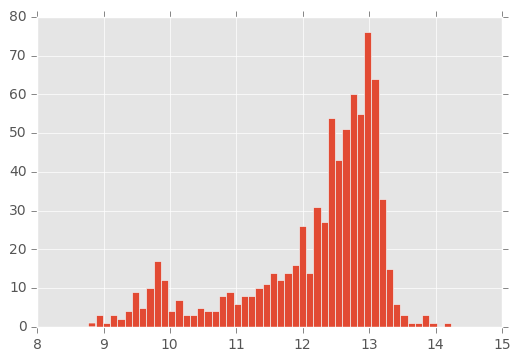

In [58]:
plt.clf()
plt.hist(cluster_features_averages["tm6_tm3_packing"].dropna().values, bins=50)
plt.show()

In [59]:
cluster_features_averages["tm6_tm3_packing"].dropna().shape

(778,)

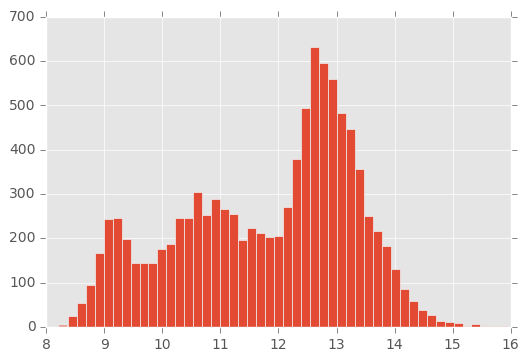

In [86]:
plt.clf()
plt.hist(apo_features_eq["tm6_tm3_packing"], bins=50)
plt.show()

In [69]:

all_traj_features_np = [f.values for f in all_traj_features_apo]

cluster_features_averages = calculate_cluster_averages_per_feature(apo_pp_clusterer, all_traj_features_np)
cluster_features_averages = pd.DataFrame(cluster_features_averages, columns=all_traj_features_apo[0].columns)

intermediate_actives = cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] > 12.)].index.values
msm_intermediate_actives = np.concatenate(apo_pp_msm.partial_transform(intermediate_actives))
order = np.argsort(apo_pp_msm.populations_[msm_intermediate_actives])
print(np.sum(apo_pp_msm.populations_[msm_intermediate_actives][order]))
print(intermediate_actives[order])

tpt_paths_features = []
for tpt_path in inv_tpt_paths:
    tpt_paths_features.append(cluster_features_averages.iloc[tpt_path])

0.541780874327
[316  61 387 274 750 122 152 228 400 270  65 547 556 563 840 322 491 900
 684 306 736   5 703 145 413 677 804 751 140 694 351   8 354 230 289 801
 437 201 778 565 342 892  63 852 165 464 129 808 442 445 724 401 655 447
 682 383 335 620 330 613 796 250 312 855  30 311 135 710 368 470 315 763
 131 111  49 845 100 668 225 874 746 520 552 376 149 206 117 334 817 479
 517 184 877 819 768  37 347 577 875 423 715 760 585 742 797 512 205 356
 708 642 901 324  70 604 362 511 685 241 630 869 758 569 583 275 163 627
 327 501 279 419  90 870  34 282 580 361 579 872 305 519 126  39 283 824
 509 523 427 249 823 854  82 644 435 271 825 246 415 919 793 700 856 300
 853  46 624 897 889 830 440 508 436 242 810 921 522 525 884 560 651 307
 851 586 594 697 170 395 221 673 660 832 507 252 390 332  50 374 887 827
 166 588 433 483 358 481 339 214 773 895 559 191 902 909 603 787 502  99
 737 633  93 711 466 912 328 227 866 739 177 118 404 675 543 873 645 590
 637 879 393 287 838 831 740 155  52

In [96]:
all_traj_features_np[3]

array([[  8.2964009 ,   5.56757331,   3.37937415, ...,  12.93357849,
         12.76740074,  11.36816382],
       [  7.70692766,   5.37829399,   3.20774764, ...,  13.05296898,
         12.93046474,  11.34003997],
       [  7.89181113,   5.47725737,   3.65408093, ...,  13.06419754,
         12.89238453,  10.66547036],
       ..., 
       [  7.43590772,   5.56317031,   3.68373305, ...,  13.17206955,
         13.83950353,  10.11322141],
       [  7.25471556,   5.30471802,   3.79323184, ...,  12.55526066,
         13.64586711,  10.6198597 ],
       [  7.53768802,   5.4780823 ,   3.80904526, ...,  12.88766098,
         13.88988495,  10.83943367]])

In [105]:
prot_features = list(set([str(g) for l in suf_pp_tIC_features for g in l]))
f1 = pd.concat([f*10. for f in protein_top_features_apo], axis=0)
f2 = pd.concat([f for f in apo_tica_dfs])
f3 = pd.concat([f for f in apo_pnas_dfs])
prot_lig_features = pd.concat([f1,f2,f3],axis=1)
all_traj_features_apo = [pd.concat([protein_top_features_apo[i]*10., apo_tica_dfs[i], apo_pnas_dfs[i]], axis=1) for i in range(0, len(apo_tica_dfs))]



all_traj_features_np = [f.values for f in all_traj_features_apo]
cluster_features_averages = calculate_cluster_averages_per_feature(apo_pp_clusterer, all_traj_features_np)
cluster_features_averages = pd.DataFrame(cluster_features_averages, columns=all_traj_features_apo[0].columns)

intermediate_actives = cluster_features_averages.loc[(cluster_features_averages["ASP114 to TYR336"] > 11.) & (cluster_features_averages["tm6_tm3_packing"] > 12.)].index.values
msm_intermediate_actives = apo_pp_msm.partial_transform(intermediate_actives)[0]
order = np.argsort(suf_pp_msm.populations_[msm_intermediate_actives])
print(suf_pp_msm.populations_[msm_intermediate_actives][order])
print(intermediate_actives)
print(intermediate_actives[order])

[ 0.00012426  0.00047492  0.00133125]
[157 636 642]
[636 642 157]


In [ ]:
tpt_paths_features[6]["Lig900-N1 to Tyr326"]

In [ ]:
print(cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] > 12.) & (cluster_features_averages["(PHE156, SER196)"] > 9.5) & (cluster_features_averages["(PHE156, SER196)"] < 10.5)].index)
print(cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] > 12.) & (cluster_features_averages["(PHE156, SER196)"] > 6.) & (cluster_features_averages["(PHE156, SER196)"] < 7.)].index)

In [ ]:
print(cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] < 11.) & (cluster_features_averages["(ASP114, TYR336)"] > 8.)& (cluster_features_averages["(Lig900-C19, Ile322)"] > 5.)].index)

In [ ]:
plt.hist(features_eq["Lig900-N1 to Tyr326"], bins=200)
plt.show()

In [ ]:
cluster_features_averages.loc[(cluster_features_averages["mOR tIC.6"] > 4.)].index

In [ ]:
cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] < 10.) & (cluster_features_averages["rmsd_npxxy_inactive"]<0.3)].index

In [ ]:
cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] > 13.) & (cluster_features_averages["rmsd_npxxy_inactive"]<0.3)].index

In [ ]:
cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] > 12.) & (cluster_features_averages["(VAL89_CA, TYR336_CA)"] >11.5)].index

In [ ]:
g = sns.PairGrid(prot_lig_features[["tm6_tm3_packing", "tIC.3", "(Lig900-C20, Gln124)", "(Lig900-C3, Trp293)"]])
g.map_diag(plt.hist, bins=100)
#g.map_upper(sns.kdeplot, cmap="Blues_d", n_levels=10, shade=True, shade_lowest=False)
g.map_upper(hexbin, color="purple", n_colors=30, gridsize=30)
g.map_lower(plt.scatter, s=.1)

In [ ]:
protein_top_features[0].iloc[::3]

In [ ]:
import seaborn as sns

In [ ]:
pmdf

In [ ]:
try:
    plt.rcParams['xtick.labelsize'] = 6.
    plt.rcParams['ytick.labelsize'] = 8.
    g = sns.clustermap(pmdf, figsize=(10,10))
    plt.show()
except:
    pass

In [ ]:
prot_lig_features.plot(kind='scatter', x="(MET281_CA, MET161_CA)", y= "(Lig900-C10, Val236)")

In [ ]:
plmf.columns.values

In [56]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *
if not os.path.exists("%s/rfr_r2_scores.h5" %analysis_dir):
    r2_scores, importances = compute_rf_matrix(tica_resampled, suf_pp_tica, n_trees=500, n_folds=10)
    verbosedump(r2_scores, "%s/rfr_r2_scores.h5" %analysis_dir)
    verbosedump(importances, "%s/rfr_importances.h5" %analysis_dir)
else:
    r2_scores = verboseload("%s/rfr_r2_scores.h5" %analysis_dir)
    importances = verboseload("%s/rfr_importances.h5" %analysis_dir)

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-normalized/analysis_n_clusters1000_random/rfr_r2_scores.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-normalized/analysis_n_clusters1000_random/rfr_importances.h5"...


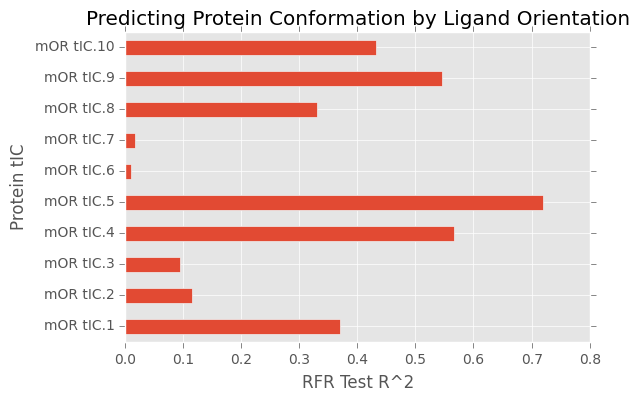

In [ ]:
r2_scores_df = pd.Series(r2_scores, index=["mOR tIC.%d" %i for i in range(1, len(r2_scores)+1)])
title = "Predicting Protein Conformation by Ligand Orientation"
r2_scores_df.plot(kind='barh', title=title)
plt.xlabel("RFR Test R^2")
plt.ylabel("Protein tIC")
plt.savefig("%s/%s.pdf" %(analysis_dir, title))
plt.show()

In [94]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *
#if not os.path.exists("%s/rfr_r2_scores.h5" %analysis_dir):
#pd.concat([pp_features_eq, suf_features_eq, pp_tica_eq, suf_tica_eq, suf_pnas_eq], axis=1)
#y = pd.concat([pp_tica_eq, suf_pnas_eq["tm6_tm3_packing", "rmsd_npxxy_active"]], axis=1)

y = pd.concat([features_eq[protein_top_features[0].columns], features_eq[sorted(feature_name_residues_dict.keys())], features_eq[["mOR tIC.%d" %i for i in range(1,pp_n_components+1)]]],axis=1)
x = features_eq[[str(f) for f in new_feature_names]]

if not os.path.exists("%s/all_features_rfr_r2_scores.h5" %analysis_dir):
    r2_scores, importances = compute_rf_matrix(x.values, y.values, n_trees=500, n_folds=10)
    verbosedump(r2_scores, "%s/all_features_rfr_r2_scores.h5" %analysis_dir)
    verbosedump(importances, "%s/all_features_rfr_importances.h5" %analysis_dir)
else:
    r2_scores = verboseload("%s/all_features_rfr_r2_scores.h5" %analysis_dir)
    importances = verboseload("%s/all_features_rfr_importances.h5" %analysis_dir)

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-normalized/analysis_n_clusters1000_random/all_features_rfr_r2_scores.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-normalized/analysis_n_clusters1000_random/all_features_rfr_importances.h5"...


In [95]:
r2_scores_df = pd.Series(r2_scores, index=y.columns)
title = "Predicting Protein Conformation by Ligand Orientation"
r2_scores_df.plot(kind='barh', title=title)
plt.xlabel("RFR Test R^2")
plt.ylabel("Protein Feature")
plt.savefig("%s/all_features_%s.pdf" %(analysis_dir, title))

In [96]:
print(importances.shape)
print(y.shape)
print(x.shape)

(158, 147)
(9943, 147)
(9943, 158)


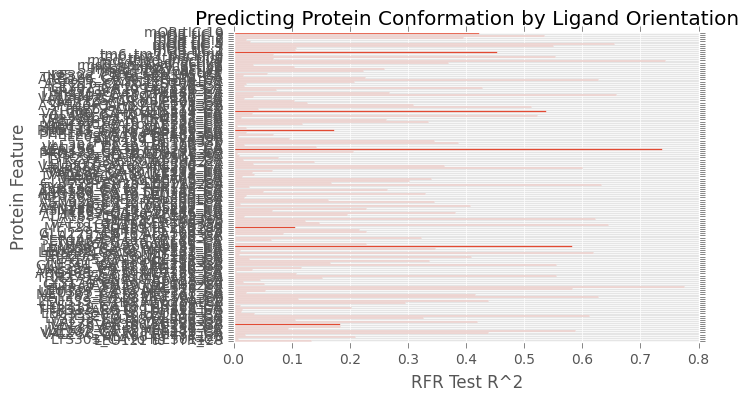

In [97]:
plt.show()

In [98]:
r2_scores_df["tm6_tm3_packing"]

0.55340516626481562

In [ ]:
#pearson_matrix = compute_pearson_matrix(x.values, y.values)
#pearson_df = pd.DataFrame(pearson_matrix, columns=y.columns, index=x.columns)
pearson_df["tm6_tm3_packing"].abs().sort(inplace=False)

In [102]:
importances_df = pd.DataFrame(importances, columns=y.columns, index=x.columns)
importances_df["tm6_tm3_packing"].abs().sort(inplace=False, ascending=False).iloc[:30]



Lig900-C10 to Tyr148    0.073075
Lig900-C9 to Tyr148     0.063977
Lig900-O1 to Tyr148     0.057200
Lig900-C11 to Tyr148    0.055814
Lig900-C16 to Gln124    0.051005
Lig900-C12 to Tyr148    0.050107
Lig900-C1 to Tyr148     0.039012
Lig900-C13 to Tyr148    0.036208
Lig900-C8 to Gly325     0.034329
Lig900-C5 to Tyr326     0.033923
Lig900-C17 to Tyr326    0.032627
Lig900-C5 to Met151     0.026289
Lig900-N2 to Tyr148     0.025545
Lig900-C7 to Met151     0.025467
Lig900-C15 to Gln124    0.021294
Lig900-C16 to Val300    0.020772
Lig900-C6 to Met151     0.020678
Lig900-C14 to Gln124    0.019117
Lig900-C16 to Tyr326    0.017793
Lig900-C8 to Met151     0.017083
Lig900-O2 to Gln124     0.015770
Lig900-C2 to Tyr148     0.013254
Lig900-C5 to Trp293     0.012889
Lig900-C19 to Thr120    0.012806
Lig900-C7 to Gly325     0.012583
Lig900-C25 to Trp133    0.010097
Lig900-C21 to Thr120    0.009421
Lig900-C3 to Ala117     0.008754
Lig900-C24 to Gln124    0.008624
Lig900-C18 to Tyr326    0.007993
Name: tm6_

In [ ]:
#import matplotlib
#matplotlib.style.use('ggplot')
#from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from plots import *
sc = StandardScaler()

#importances_scaled = pearson_matrix.T
#importances_scaled = sc.fit_transform(importances)
importances_scaled = copy.deepcopy(importances)
#for j in range(0, importances_scaled.shape[1]):
#    importances_scaled[:,j] *= r2_scores[j]

responses_to_keep = np.where(np.array(r2_scores) > 0.5)[0]
importances_scaled = importances_scaled[:,responses_to_keep]
predictors_to_keep = list(set(np.where(importances_scaled > 0.03)[0].tolist()))
print(responses_to_keep)
print(predictors_to_keep)
importances_scaled = importances_scaled[predictors_to_keep,:]
print(len(responses_to_keep))

#row_labels = ["suf tIC.%d" %i for i in range(1, n_components+1)]
#column_labels = ["mOR tIC.%d" %i for i in range(1, pp_n_components+1)]
row_labels = x.columns.values[predictors_to_keep]
column_labels = y.columns.values[responses_to_keep]

importance_df = pd.DataFrame(importances_scaled, columns=column_labels, index=row_labels)

plot_clustermap(importance_df, save_file="%s/all_features_rfr_feature_importances.pdf" %(analysis_dir), method='average', row_cluster=False, col_cluster=False, z_score=None, xtick_labelsize=8, ytick_labelsize=8)
plt.show()

"""

plot_clustermap(importances_df, save_file="%s/feature_importances.pdf" %(save_dir, experiment_name), method='average', z_score=None)



fig = plt.figure()
ax = fig.add_subplot(111)
heatmap = ax.pcolor(np.abs(pearson_matrix), cmap=plt.cm.Blues)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(pearson_matrix.shape[0])+0.5, minor=False)
ax.set_yticks(np.arange(pearson_matrix.shape[1])+0.5, minor=False)

# want a more natural, table-like display
#ax.invert_yaxis()
#ax.xaxis.tick_top()

ax.set_xticklabels(row_labels, minor=False, rotation=270)
ax.set_yticklabels(column_labels, minor=False)
fig.subplots_adjust(bottom=0.2)

fig.savefig("%s/suf_vs_pp_pearson_heatmap.svg" % analysis_dir, format='svg', dpi=1200)
plot_file = "%s/suf_vs_pp_pearson_heatmap.pdf" % analysis_dir
pp = PdfPages(plot_file)

pp.savefig(fig)

pp.close()  
plt.show()
"""

In [ ]:
from jointplot_d3 import *
titles_j = [f for f in features_eq.columns.values if "Lig" in f and "Tyr326" in f]
print(titles_j)
jointplots(features_eq[titles_j].values, analysis_dir, titles=titles_j,
                           main = "mOR MSM", refcoords=None, refcoords_j=None, axes=None,
                               data_j=features_eq[["tm6_tm3_packing"]].values, titles_j=["tm6_tm3_packing"], reshape=False, max_tIC=20, 
                               min_density=None, max_diff=5., custom_lims=None, 
                               n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)
                    

r2_scores

In [ ]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *

def make_msm_features_plots(importances, plmf, top_features_per_tIC_i, top_features_per_tIC_j, n_combs=3, r2s = None, n_tICs=3,
                            features=None, max_features=2,
                            subsample=1, smoothing=100, title="Key Measurements", custom_features=None,
                            make_jointplots=True, features_eq=None, n_lig_tICs=3, ref_df=None, save_dir=None):
    corr_matrix = importances.T
    ori_shape = np.shape(corr_matrix)
    
    if r2s is None:
        r2s = np.max(importances, axis=0)
    
    suf_order = np.argsort(-1.0*r2s)
    all_features = []
    if features is None:
        for k, prot_idx in enumerate(suf_order):
            if k == n_tICs:
                break
            lig_order = np.argsort(-1.0*importances[:,prot_idx])
            #if prot_idx != 9: continue
            print(lig_order)
            for l, lig_idx in enumerate(lig_order):
                if l == n_lig_tICs:
                    break
            
                features = []

                print("mOR tIC.%d" %(k+1))
                prot_features = ["mOR tIC.%d" %(prot_idx+1)]
                if custom_features is not None:
                    prot_features += custom_features[0]
                lig_features = ["suf tIC.%d" %(lig_idx+1)]
                all_prot_features = [str(f) for f in top_features_per_tIC_i[prot_idx]]
                all_lig_features = [str(f) for f in top_features_per_tIC_j[lig_idx]]
                pearson_matrix = compute_pearson_matrix(plmf[all_prot_features].values, plmf[all_lig_features].values)
                pearson_shape = pearson_matrix.shape
                inds = np.dstack(np.unravel_index(np.argsort(-1.0*np.abs(pearson_matrix).ravel()), pearson_shape))[0]
                prot_inds = []
                lig_inds = []

                for j, ind in enumerate([idx[0] for idx in inds]):
                    if len(prot_inds) == max_features: break
                    if ind in prot_inds: continue
                    prot_features.append(str(top_features_per_tIC_i[prot_idx][ind]))
                    prot_inds.append(ind)

                if custom_features is not None:
                    features += custom_features[0]

                for j, ind in enumerate([idx[1] for idx in inds]):
                    if len(lig_inds) == max_features: break
                    if ind in lig_inds: continue
                    lig_features.append(str(top_features_per_tIC_j[lig_idx][ind]))
                    lig_inds.append(ind)

                if make_jointplots:
                    print("Creating joint deltaG plots.")
                    data_i = features_eq[prot_features+all_prot_features].values
                    print(data_i.shape)
                    data_j = features_eq[lig_features+all_lig_features].values
                    print(data_j.shape)
                    tic_save_dir = "%s/mOR_tIC%d_vs_suf_tIC%d" %(save_dir, prot_idx+1, lig_idx+1)
                    if not os.path.exists(tic_save_dir):
                        os.makedirs(tic_save_dir)
                    #else:
                    #    continue
                    
                    
                    if ref_df is not None:
                        refcoords = ref_df[prot_features+all_prot_features].values
                        print(refcoords.shape)
                        refcoords_j = ref_df[lig_features+all_lig_features].values
                        print(refcoords_j.shape)
                    else:
                        refcoords = None
                        refcoords_j = None

                    jointplots(data_i, tic_save_dir, titles=prot_features+all_prot_features,
                           main = "mOR MSM", refcoords=refcoords, refcoords_j=refcoords_j, axes=None,
                               data_j=data_j, titles_j=lig_features+all_lig_features, reshape=False, max_tIC=20, 
                               min_density=None, max_diff=5., custom_lims=None, 
                               n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)
                    
                    jointplots(data_i, tic_save_dir, titles=prot_features+all_prot_features,
                               main = "mOR MSM", refcoords=refcoords, axes=None,
                               data_j=None, titles_j=None, reshape=False, max_tIC=20, 
                               min_density=None, max_diff=5., custom_lims=None, 
                               n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)
                    
                    jointplots(data_j, tic_save_dir, titles=lig_features+all_lig_features,
                           main = "mOR MSM", refcoords=refcoords_j, refcoords_j=refcoords, axes=None,
                               data_j=data_i, titles_j=prot_features+all_prot_features, reshape=False, max_tIC=20, 
                               min_density=None, max_diff=5., custom_lims=None, 
                               n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)

                features += (prot_features + lig_features)
    
                #plot_df_rolling(plmf[features].iloc[::subsample], "%s/key_measurements_tIC%d.pdf" %(save_dir, prot_idx+1), True, smoothing=smoothing, include_original=False, subplots=True, min_periods=None)
                #plt.show()  
                all_features.append(features)
    #features = ["tm6_tm3_packing", "rmsd_npxxy_active"]
    #features = ["mOR tIC.1", "mOR tIC.4", "mOR tIC.5"]
    #inds = np.dstack(np.unravel_index(np.argsort(-1.0*np.abs(corr_matrix).ravel()), ori_shape))[0]
    return all_features

jointplots_refcoords_dir = "%s/refcoords_jointplots" %analysis_dir
if not os.path.exists(jointplots_refcoords_dir):
    os.makedirs(jointplots_refcoords_dir)

jointplots_dir = "%s/jointplots" %analysis_dir
if not os.path.exists(jointplots_dir):
    os.makedirs(jointplots_dir)

all_features= make_msm_features_plots(importances, protein_ligand_msm_featurized,
                                      suf_pp_tIC_features, all_tIC_features, n_combs=5,
                                      r2s = np.array(r2_scores), subsample=1, smoothing=100,
                                      n_tICs=3, max_features=1,
                                      #custom_features = None,
                                      custom_features=[["tm6_tm3_packing", "rmsd_npxxy_active", "rmsd_npxxy_inactive"], [], []], 
                                      make_jointplots=True, features_eq=features_eq, ref_df=ref_features, save_dir=jointplots_refcoords_dir)
#custom_features = ["mOR tIC.4", "(ASN150, PHE289)", "(ASP114, TYR336)", "suf tIC.4", "(Lig900-C7, Trp293)", "mOR tIC.2", "(MET281_CA, MET161_CA)", "(GLN124, TYR326)", "suf tIC.2", "(Lig900-N1, Tyr326)", "(Lig900-C26, Tyr326)"]
#plot_features = make_msm_features_plot(importances, protein_ligand_msm_featurized, suf_pp_tIC_features, all_tIC_features, n_combs=5, r2s = np.array(r2_scores), features=custom_features)


#plot_features
#make_msm_features_plot(pearson_matrix, pd.DataFrame(suf_pp_tica, columns=["mOR tIC.%d" %i for i in range(1,6)]), suf_pp_tIC_features, all_tIC_features, n_combs=2)

In [ ]:
protein_ligand_msm_featurized.columns.values.tolist()

In [103]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *

def make_msm_features_plots(importances, plmf, features_i, features_j, n_combs=3, r2s = None, n_tICs=3,
                            features=None, max_features=2,
                            subsample=1, smoothing=100, title="Key Measurements", custom_features=None,
                            make_jointplots=True, features_eq=None, n_lig_tICs=30, ref_df=None, save_dir=None):
    corr_matrix = importances.T
    ori_shape = np.shape(corr_matrix)
    
    if r2s is None:
        r2s = np.max(importances, axis=0)
    
    suf_order = np.argsort(-1.0*r2s)
    all_features = []
    if features is None:
        for k, prot_idx in enumerate(suf_order):
            if k == n_tICs:
                break
            lig_order = np.argsort(-1.0*importances[:,prot_idx])
            
            if "tm" not in str(features_i[prot_idx]): continue
            
            all_prot_features = [str(features_i[prot_idx])]
            all_lig_features = [str(features_j[lig_idx]) for lig_idx in lig_order[:n_lig_tICs]]
            

            features = []
            prot_features = []
            lig_features = []

            if make_jointplots:
                print("Creating joint deltaG plots.")
                data_i = features_eq[prot_features+all_prot_features].values
                print(data_i.shape)
                data_j = features_eq[lig_features+all_lig_features].values
                print(data_j.shape)

                if ref_df is not None:
                    refcoords = ref_df[prot_features+all_prot_features].values
                    print(refcoords.shape)
                    refcoords_j = ref_df[lig_features+all_lig_features].values
                    print(refcoords_j.shape)
                else:
                    refcoords = None
                    refcoords_j = None

                jointplots(data_i, save_dir, titles=prot_features+all_prot_features,
                       main = "mOR MSM", refcoords=refcoords, refcoords_j=refcoords_j, axes=None,
                           data_j=data_j, titles_j=lig_features+all_lig_features, reshape=False, max_tIC=20, 
                           min_density=None, max_diff=5., custom_lims=None, 
                           n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)
                
                jointplots(data_j, save_dir, titles=lig_features + all_lig_features, 
                       main = "mOR MSM", refcoords=refcoords_j, refcoords_j=refcoords, axes=None,
                           data_j=data_i, titles_j=prot_features+all_prot_features, reshape=False, max_tIC=20, 
                           min_density=None, max_diff=5., custom_lims=None, 
                           n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)
                
                jointplots(np.hstack([data_i, data_j]), save_dir, titles=prot_features+all_prot_features+lig_features+all_lig_features,
                       main = "mOR MSM", refcoords=np.hstack([refcoords, refcoords_j]), refcoords_j=ref_df[custom_features[0]].values, axes=None,
                           data_j=features_eq[custom_features[0]].values, titles_j=custom_features[0], reshape=False, max_tIC=20, 
                           min_density=None, max_diff=5., custom_lims=None, 
                           n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)

    #features = ["tm6_tm3_packing", "rmsd_npxxy_active"]
    #features = ["mOR tIC.1", "mOR tIC.4", "mOR tIC.5"]
    #inds = np.dstack(np.unravel_index(np.argsort(-1.0*np.abs(corr_matrix).ravel()), ori_shape))[0]
    return all_features

jointplots_refcoords_dir = "%s/refcoords_jointplots" %analysis_dir
if not os.path.exists(jointplots_refcoords_dir):
    os.makedirs(jointplots_refcoords_dir)

jointplots_dir = "%s/jointplots" %analysis_dir
if not os.path.exists(jointplots_dir):
    os.makedirs(jointplots_dir)

all_features= make_msm_features_plots(importances, protein_ligand_msm_featurized,
                                      y.columns, x.columns, n_combs=5,
                                      r2s = np.array(r2_scores), subsample=1, smoothing=100,
                                      n_tICs=25, max_features=1,
                                      #custom_features = None,
                                      custom_features=[[], [], []], 
                                      make_jointplots=True, features_eq=features_eq, ref_df=ref_features, save_dir=jointplots_refcoords_dir)
#custom_features = ["mOR tIC.4", "(ASN150, PHE289)", "(ASP114, TYR336)", "suf tIC.4", "(Lig900-C7, Trp293)", "mOR tIC.2", "(MET281_CA, MET161_CA)", "(GLN124, TYR326)", "suf tIC.2", "(Lig900-N1, Tyr326)", "(Lig900-C26, Tyr326)"]
#plot_features = make_msm_features_plot(importances, protein_ligand_msm_featurized, suf_pp_tIC_features, all_tIC_features, n_combs=5, r2s = np.array(r2_scores), features=custom_features)


#plot_features
#make_msm_features_plot(pearson_matrix, pd.DataFrame(suf_pp_tica, columns=["mOR tIC.%d" %i for i in range(1,6)]), suf_pp_tIC_features, all_tIC_features, n_combs=2)

Creating joint deltaG plots.
(9943, 1)
(9943, 30)
(2, 1)
(2, 30)
Making delta G plots.
Done plotting columns
Making delta G plots.
i=0
j=0
(9943, 1)
(9943, 30)
i=0
j=1
(9943, 1)
(9943, 30)
i=0
j=2
(9943, 1)
(9943, 30)
i=0
j=3
(9943, 1)
(9943, 30)
i=0
j=4
(9943, 1)
(9943, 30)
i=0
j=5
(9943, 1)
(9943, 30)
i=0
j=6
(9943, 1)
(9943, 30)
(2, 9943)
Computed 2D KDE
min_density=0.0
Computed Density. Now plotting.
(0.0, 5.0)
[[  9.15980816   3.76306391]
 [ 13.01761985   3.70322561]]
i=0
j=7
(9943, 1)
(9943, 30)
(2, 9943)
Computed 2D KDE
Computed Density. Now plotting.
(0.0, 5.0)
[[  9.15980816   4.63381863]
 [ 13.01761985   4.80313253]]
i=0
j=8
(9943, 1)
(9943, 30)
i=0
j=9
(9943, 1)
(9943, 30)
i=0
j=10
(9943, 1)
(9943, 30)
i=0
j=11
(9943, 1)
(9943, 30)
(2, 9943)
Computed 2D KDE
Computed Density. Now plotting.
(0.0, 5.0)
[[  9.15980816   4.27599382]
 [ 13.01761985   4.20540619]]
i=0
j=12
(9943, 1)
(9943, 30)
(2, 9943)
Computed 2D KDE
Computed Density. Now plotting.
(0.0, 5.0)
[[  9.15980816   4.1

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Computed 2D KDE
Computed Density. Now plotting.
(0.0, 5.0)
[[  9.15980816  11.23769188]
 [ 13.01761985   7.81186008]]
i=0
j=27
(9943, 1)
(9943, 30)
(2, 9943)
Computed 2D KDE
Computed Density. Now plotting.
(0.0, 5.0)
[[  9.15980816   7.3063798 ]
 [ 13.01761985   6.38203526]]
i=0
j=28
(9943, 1)
(9943, 30)
(2, 9943)
Computed 2D KDE
Computed Density. Now plotting.
(0.0, 5.0)
[[  9.15980816   6.92499065]
 [ 13.01761985   4.5501833 ]]
i=0
j=29
(9943, 1)
(9943, 30)
(2, 9943)
Computed 2D KDE
Computed Density. Now plotting.
(0.0, 5.0)
[[  9.15980816   6.67084742]
 [ 13.01761985   5.1706686 ]]
Done plotting columns
Making delta G plots.
i=0
i=2
i=4
i=6
i=8
i=10
j=0
j=0
j=0
j=0
j=0
j=0
(9943, 30)
(9943, 30)
(9943, 30)
(9943, 30)
(9943, 30)
(9943, 30)
(9943, 1)
(9943, 1)
(9943, 1)
(9943, 1)
(9943, 1)
(9943, 1)
i=1
i=3
i=5
(2, 9943)
i=9
i=11
j=0
j=0
j=0
Computed 2D KDE
j=0
j=0
(9943, 30)
(9943, 30)
(9943, 30)
min_density=0.0(9943, 30)
(9943, 30)
(9943, 1)
(9943, 1)
(9943, 1)

(9943, 1)
(9943, 1)
i

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

Done plotting columns


In [ ]:
plmf = copy.deepcopy(protein_ligand_msm_featurized)
smoothing=100
names = plmf.columns.values.tolist()
for i, name in enumerate(names):
    if "Lig900" in str(name):
        names[i] = "(suf" + name[7:]
plmf.columns = names
plot_features = plmf[["tm6_tm3_packing", "mOR tIC.5", "(MET281_CA, MET161_CA)", "(HIS319_CA, TYR75_CA)", "(suf-C4, Tyr326)", "(suf-N1, Tyr326)"]]
plot_df_rolling(plot_features.iloc[:100000], "%s/key_measurements_tIC5.png" %(jointplots_dir), True, smoothing=smoothing, include_original=False, subplots=True, min_periods=None)

In [ ]:
tpt_paths_features

In [106]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *

def make_msm_features_plots_single(importances, plmf, top_features_per_tIC_i, top_features_per_tIC_j, n_combs=3, r2s = None, n_tICs=3,
                            features=None, max_features=2,
                            subsample=1, smoothing=100, title="Key Measurements", custom_features=None,
                            make_jointplots=True, features_eq=None, n_lig_tICs=1, ref_df=None, save_dir=None, prot_pairs=[],
                            tpt_paths=None):

    for t, prot_pair in enumerate(prot_pairs):
        if t == n_tICs:
            break
        #if prot_pair[1] != 4: continue
        tIC_i, tIC_j = prot_pair
        tic_save_dir = "%s/tIC%d_tIC%d" %(save_dir, tIC_i+1, tIC_j+1)
        if not os.path.exists(tic_save_dir):
            os.makedirs(tic_save_dir)
        #else:
        #    continue
        
        features_i = ["mOR tIC.%d" %(tIC_i+1)] + [str(f) for f in top_features_per_tIC_i[tIC_i]]
        if custom_features is not None:
            features_i += custom_features[0]
        features_j = ["mOR tIC.%d" %(tIC_j+1)] + [str(f) for f in top_features_per_tIC_i[tIC_j]]
        
        data_i = features_eq[features_i].values
        data_j = features_eq[features_j].values

        if ref_df is not None:
            refcoords = ref_df[features_i].values
            refcoords_j = ref_df[features_j].values
        else:
            refcoords = None
            refcoords_j = None
        
        if tpt_paths is not None:
            paths_i = [p[features_i].values for p in tpt_paths]
            paths_j = [p[features_j].values for p in tpt_paths]
        
            paths_to_display = [p[features_i] for p in tpt_paths]
        else:
            paths_i = None
            paths_j = None
        
        jointplots(data_i, tic_save_dir, titles=features_i,
                           main = "mOR MSM", refcoords=refcoords, refcoords_j=refcoords_j, axes=None,
                           data_j=data_j, titles_j=features_j, reshape=False, max_tIC=20, 
                           min_density=None, max_diff=5., custom_lims=None, 
                           n_levels=15, worker_pool=None, parallel=True, n_pts=200j, tpt_paths=paths_i,
                           tpt_paths_j=paths_j)
                            
jointplots_refcoords_dir = "%s/refcoords_jointplots" %analysis_dir
if not os.path.exists(jointplots_refcoords_dir):
    os.makedirs(jointplots_refcoords_dir)

jointplots_dir = "%s/jointplots" %analysis_dir
if not os.path.exists(jointplots_dir):
    os.makedirs(jointplots_dir)

jointplots_tpt_dir = "%s/jointplots_tpt_annotated" %analysis_dir
if not os.path.exists(jointplots_tpt_dir):
    os.makedirs(jointplots_tpt_dir)

tics_to_examine = [1, 3, 4]
prot_pairs = []
for i in range(0, len(tics_to_examine)):
    for j in range(i+1, len(tics_to_examine)):
        prot_pairs.append((tics_to_examine[i], tics_to_examine[j]))
        prot_pairs.append((tics_to_examine[j], tics_to_examine[i]))
print(prot_pairs)
    
make_msm_features_plots_single(importances, protein_ligand_msm_featurized,
                                      suf_pp_tIC_features, all_tIC_features, n_combs=5,
                                      r2s = np.array(r2_scores), subsample=1, smoothing=100,
                                      n_tICs=10, max_features=1,
                                      #custom_features = None,
                                      custom_features=[["tm6_tm3_packing", "rmsd_npxxy_active", "rmsd_npxxy_inactive"], [], []], 
                                      make_jointplots=True, features_eq=features_eq, ref_df=ref_features, save_dir=jointplots_refcoords_dir,
                                      prot_pairs=prot_pairs)
                                      #tpt_paths=None)
#custom_features = ["mOR tIC.4", "(ASN150, PHE289)", "(ASP114, TYR336)", "suf tIC.4", "(Lig900-C7, Trp293)", "mOR tIC.2", "(MET281_CA, MET161_CA)", "(GLN124, TYR326)", "suf tIC.2", "(Lig900-N1, Tyr326)", "(Lig900-C26, Tyr326)"]
#plot_features = make_msm_features_plot(importances, protein_ligand_msm_featurized, suf_pp_tIC_features, all_tIC_features, n_combs=5, r2s = np.array(r2_scores), features=custom_features)


#plot_features
#make_msm_features_plot(pearson_matrix, pd.DataFrame(suf_pp_tica, columns=["mOR tIC.%d" %i for i in range(1,6)]), suf_pp_tIC_features, all_tIC_features, n_combs=2)

[(1, 3), (3, 1), (1, 4), (4, 1), (3, 4), (4, 3)]
Making delta G plots.
Done plotting columns
Making delta G plots.i=0
i=1
i=2
i=3
i=4
i=5
j=0
j=0
j=0
j=0
j=0
j=0
(9943, 10)
(9943, 10)
(9943, 10)
(9943, 10)
(9943, 10)
(9943, 10)
(9943, 13)
(9943, 13)
(9943, 13)
(9943, 13)
(9943, 13)
(9943, 13)
(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
min_density=0.0min_density=0.0min_density=0.0min_density=0.0min_density=0.0min_density=0.0





Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)





[[ 1.04117773  0.25465436]
 [-0.51567353 -0.09941434]][[ 4.18775749  0.25465436]
 [ 3.59537244 -0.09941434]][[ 10.97170925   0.25465436]
 [  3.46271658  -0.09941434]][[ 12.54730225   0.25465436]
 

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)





[[ 1.04117773  5.64001799]
 [-0.51567353  5.46450138]][[ 4.18775749  5.64001799]
 [ 3.59537244  5.46450138]][[ 10.97170925   5.64001799]
 [  3.46271658   5.46450138]][[ 12.54730225   5.64001799]
 [  6.49738598   5.46450138]][[ 6.13606358  5.64001799]
 [ 5.67085743  5.46450138]][[ 5.33052254  5.64001799]
 [ 6.62273359  5.46450138]]





i=0i=1i=2i=3i=4i=5





j=7
j=7
j=7
j=7
j=7
j=7
(9943, 10)
(9943, 10)
(9943, 10)
(9943, 10)
(9943, 10)
(9943, 10)
(9943, 13)
(9943, 13)
(9943, 13)
(9943, 13)
(9943, 13)
(9943, 13)
(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Comput

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)





[[ 0.25465436  5.50412893]
 [-0.09941434  5.96564293]][[ 5.9295125   5.50412893]
 [ 9.7176075   5.96564293]][[ 5.61469364  5.50412893]
 [ 6.64069271  5.96564293]][[  8.39526081   5.50412893]
 [ 10.54314613   5.96564293]][[ 5.28732347  5.50412893]
 [ 5.01446486  5.96564293]][[ 6.20819759  5.50412893]
 [ 6.14200401  5.96564293]]





i=7i=11i=9i=6i=10i=8





j=0
j=0
j=0
j=0
j=0
j=0
(9943, 16)
(9943, 16)
(9943, 16)
(9943, 16)
(9943, 16)
(9943, 16)
(9943, 7)
(9943, 7)
(9943, 7)
(9943, 7)
(9943, 7)
(9943, 7)
(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
min_density=0.0min_density=0.0min_density=0.0min_density=0.0min_density=0.0min_density=0.0





Computed Density. Now plotting.
Computed D

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)





[[ 1.04117773  8.93306351]
 [-0.51567353  6.18403959]][[ 4.18775749  8.93306351]
 [ 3.59537244  6.18403959]][[ 10.97170925   8.93306351]
 [  3.46271658   6.18403959]][[ 12.54730225   8.93306351]
 [  6.49738598   6.18403959]][[ 6.13606358  8.93306351]
 [ 5.67085743  6.18403959]][[ 5.33052254  8.93306351]
 [ 6.62273359  6.18403959]]





i=0i=1i=2i=3i=4i=5





j=7
j=7
j=7
j=7
j=7
j=7
(9943, 10)
(9943, 10)
(9943, 10)
(9943, 10)
(9943, 10)
(9943, 10)
(9943, 14)
(9943, 14)
(9943, 14)
(9943, 14)
(9943, 14)
(9943, 14)
(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Comput

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se



j=6
j=6
j=6
j=6
j=6
j=6
(9943, 17)
(9943, 17)
(9943, 17)
(9943, 17)
(9943, 17)
(9943, 17)
(9943, 7)
(9943, 7)
(9943, 7)
(9943, 7)
(9943, 7)
(9943, 7)
(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)





[[ 7.01753807  5.50412893]
 [ 6.4855423   5.96564293]][[ 11.49536228   5.50412893]
 [  6.1882062    5.96564293]][[ 7.21754074  5.50412893]
 [ 5.87020302  5.96564293]][[ 3.83722496  5.50412893]
 [ 3.35832787  5.96564293]][[-1.60038357  5.50412893]
 [-0.03905146  5.96564293]][[ 6.55276775  5.50412893]
 [ 7.51085329  5.96564293]]





i=10i=6i=9i=7i=8i=11





j=0
j=0
j=0
j=0
j=0
j=0
(9943, 17)
(9943, 17)
(9943, 17)
(9943, 17)
(9943,

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)





[[ 0.25465436  8.93306351]
 [-0.09941434  6.18403959]][[ 5.9295125   8.93306351]
 [ 9.7176075   6.18403959]][[ 5.61469364  8.93306351]
 [ 6.64069271  6.18403959]][[  8.39526081   8.93306351]
 [ 10.54314613   6.18403959]][[ 5.28732347  8.93306351]
 [ 5.01446486  6.18403959]][[ 6.20819759  8.93306351]
 [ 6.14200401  6.18403959]]





i=0i=1i=2i=3i=4i=5





j=7
j=7
j=7
j=7
j=7
j=7
(9943, 16)
(9943, 16)
(9943, 16)
(9943, 16)
(9943, 16)
(9943, 16)
(9943, 14)
(9943, 14)
(9943, 14)
(9943, 14)
(9943, 14)
(9943, 14)
(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)(2, 9943)
(2, 9943)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE

Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed 2D KDE
Computed Density. Now plotting.Computed D

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se





Computed 2D KDE
(9943, 14)
(9943, 14)
(9943, 16)
j=10
(2, 9943)
(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)Computed Density. Now plotting.(2, 9943)
(2, 9943)
(9943, 14)
(9943, 16)
Computed 2D KDE







Computed 2D KDE
Computed 2D KDE
(2, 9943)
(9943, 14)
Computed Density. Now plotting.[[-1.60038357  5.9295125 ]
 [-0.03905146  9.7176075 ]][[ 6.55276775  5.9295125 ]
 [ 7.51085329  9.7176075 ]][[ 3.83722496  5.9295125 ]
 [ 3.35832787  9.7176075 ]][[ 7.21754074  5.9295125 ]
 [ 5.87020302  9.7176075 ]][[ 11.49536228   5.9295125 ]
 [  6.1882062    9.7176075 ]][[ 7.01753807  5.9295125 ]
 [ 6.4855423   9.7176075 ]](0.0, 5.0)Computed Density. Now plotting.Computed Density. Now plotting.Computed 2D KDE
(2, 9943)










Computed Density. Now plotting.Computed 2D KDE
(0.0, 5.0)i=0i=1i=2i=3i=4i=5[[  5.64001799  11.37884331]
 [  5.46450138   8.582757  ]](0.0, 5.0)(0.0, 5.0)
Computed Density. Now plotting.









(0.0, 5.0)
[[  5.36794567  11.37884331]
 [  5.36768675   8.58

In [ ]:
protein_ligand_msm_featurized.columns.values

In [ ]:
features_eq[all_prot_features].values

In [ ]:
features_eq.columns

In [ ]:
suf_

In [ ]:
custom_features_4 = ["mOR tIC.4", "(ASN150, PHE289)", "(ASP114, TYR336)", "(HIS319, TYR75)", "suf tIC.4", "(Lig900-C7, Tyr75)", "(Lig900-C7, Trp293)"]
make_msm_features_plot(importances, protein_ligand_msm_featurized, suf_pp_tIC_features, all_tIC_features, n_combs=5, r2s = np.array(r2_scores), features=custom_features_4, title="Key Measurements: mOR tIC.4")


In [ ]:
custom_features_2 = ["mOR tIC.2", "(MET281_CA, MET161_CA)", "(GLN124, TYR326)", "suf tIC.2", "(Lig900-N1, Tyr326)", "(Lig900-C26, Tyr326)"]

make_msm_features_plot(importances, protein_ligand_msm_featurized, suf_pp_tIC_features, all_tIC_features, n_combs=5, r2s = np.array(r2_scores), features=custom_features_2, title="Key Measurements: mOR tIC.2")




In [ ]:
print(importances)

In [ ]:
protein_top_features[0]

In [67]:
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
coords_bounds_dict = {"tm6_tm3_packing": [(8.0, 10.), (12., 15.)]}
all_traj_files = get_trajectory_files(traj_dir, traj_ext)
trajs_to_watch = reaction_coordinate_sampler([all_traj_files[i] for i in suf_trajs], ".h5", [t.values for t in all_traj_features], 
                            all_traj_features[0].columns.values.tolist(), coords_bounds_dict, 
                            "%s/trajs_to_watch.csv" %pp_tica_dir)

Analyzing tm6_tm3_packing
{'tm6_tm3_packing': [(44, 'bu72_rep_139.h5'), (239, 'bu72_rep_84.h5'), (258, 'bu72_reseeded_rep_100.h5'), (278, 'bu72_reseeded_rep_119.h5'), (344, 'bu72_reseeded_rep_179.h5'), (350, 'bu72_reseeded_rep_184.h5'), (352, 'bu72_reseeded_rep_186.h5'), (412, 'bu72_reseeded_rep_24.h5'), (429, 'bu72_reseeded_rep_255.h5'), (432, 'bu72_reseeded_rep_27.h5'), (464, 'bu72_reseeded_rep_56.h5'), (466, 'bu72_reseeded_rep_58.h5'), (467, 'bu72_reseeded_rep_59.h5'), (472, 'bu72_reseeded_rep_63.h5'), (473, 'bu72_reseeded_rep_64.h5'), (494, 'bu72_reseeded_rep_83.h5')]}


In [68]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *
for tup in [t for t in trajs_to_watch['tm6_tm3_packing']]:
    i = tup[0]
    name = tup[1]
    featurized_traj = all_traj_features[i]
    df = copy.deepcopy(featurized_traj[["tm6_tm3_packing", "ARG165_CA to TYR336_CA", "PHE338 to PHE84", 'Lig900-C16 to Tyr326', 'Lig900-C5 to Tyr326', "CYS159 to TYR336", "PHE289 to TYR336", "TYR326_CA to SER119_CA"]])
    plot_df_rolling(df, "%s/%s.png" %(analysis_dir, name), return_fig=True, subplots=True, smoothing=10, include_original=True, min_periods=1, ref_df=ref_features)

we are operating on biox3


In [ ]:
test_df = pd.DataFrame(ref_features["Lig900-C21 to Tyr326"])
test_df = pd.concat([test_df.transpose()]*5)
test_df

In [ ]:
[f for f in all_traj_features[0].columns.values.tolist() if "Tyr326" in f]

In [ ]:
coords_bounds_dict = {"tm6_tm3_packing": [8.0, 10., 12.0, 16.0]}
trajs_to_watch = reaction_coordinate_sampler(traj_dir, ".h5",user_defined_coords, 
                            sorted(feature_name_residues_dict.keys()), coords_bounds_dict, 
                            "%s/trajs_to_watch.csv" %pp_tica_dir)
print([t for t in trajs_to_watch.values()[0] if "suf" in t])

In [ ]:
suf_pp_pnas.shape

In [ ]:
pearson_matrix

In [ ]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *
plt.clf()

import matplotlib
reload(matplotlib)
from matplotlib import pyplot as plt

# changing matplotlib the default style
matplotlib.style.use('ggplot')

feature0 = []
#feature0 +=  [name for name in protein_ligand_msm_featurized.columns.values if "336" in name and "159" in name and "CA" not in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tm6_tm3_packing" in name]


#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "LEU88" in name and "PHE338" in name and "CA" not in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "PHE289" in name and "TYR336" in name and "CA" not in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "66_C" in name and "71_C" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "npxxy_inactive" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tIC.4" in name and "mOR" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "281_C" in name and "161_C" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "278_C" in name and "283_C" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "114" in name and "336" in name]

feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tIC.4" in name and "suf" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Tyr75" in name and "Lig900-C21" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Ile322" in name and "Lig900-C21" in name]

plot_df_rolling(protein_ligand_msm_featurized[feature0].iloc[::100], "%s/key_measurements_mOR_tIC4.pdf" %analysis_dir, True, smoothing=10, include_original=True, subplots=True, min_periods=None)
plt.show()

In [ ]:
plmf.columns.values

In [ ]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *
plt.clf()

import matplotlib
reload(matplotlib)
from matplotlib import pyplot as plt

# changing matplotlib the default style
matplotlib.style.use('ggplot')

feature0 = []
#feature0 +=  [name for name in protein_ligand_msm_featurized.columns.values if "336" in name and "159" in name and "CA" not in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tm6_tm3_packing" in name]


#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "LEU88" in name and "PHE338" in name and "CA" not in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "PHE289" in name and "TYR336" in name and "CA" not in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "66_C" in name and "71_C" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "npxxy_inactive" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tIC.4" in name and "mOR" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "114" in name and "336" in name and "CA" not in name]
feature0 += ['(Phe338_Ca, Arg280_Ca)'.upper()]

feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tIC.3" in name and "suf" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-C7" in name and "Gln124" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-N1" in name and "Gln124" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-C17" in name and "Tyr326" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-C17" in name and "Leu121" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-C7" in name and "Asn150" in name]

feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tIC.4" in name and "suf" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-C7" in name and "Tyr75" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-N1" in name and "Ile298" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-O1" in name and "Cys235" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-C7" in name and "Trp293" in name]

#2    Lig900-C7-Tyr75   Lig900-C7   Tyr75      900       75    0.740407   
###   Lig900-N1-Ile298   Lig900-N1  Ile298      900      298   -0.571373   
#1 # Lig900-O1-Cys235   Lig900-O1  Cys235      900      235    0.367512   
#3   Lig900-C7-Trp293   Lig900-C7  Trp293      900      293    0.286380   


plot_df_rolling(protein_ligand_msm_featurized[feature0], "%s/key_measurements_mOR_tIC4.pdf" %analysis_dir, True, smoothing=100, include_original=True, min_periods=None)
plt.show()

In [ ]:
protein_ligand_msm_featurized.columns.values

In [ ]:
'(Phe338_Ca, Arg280_Ca)'.upper()

In [ ]:
"%s/key_measurements.pdf" %analysis_dir

In [ ]:
import plots
reload(plots)
from plots import *
suf_pp_tica = verboseload("%s/suf_tica_msm_lag-time10_prior-counts0.0_clusters1000_resampled_10000.h5" %pp_tica_dir)
#plot_data_vs_data(tica_resampled, suf_pp_tica, ["suf-BP_tIC%d" %i for i in range(1,n_components+1)], ["mOR-PP_tIC%d" %i for i in range(1,n_components+1)], analysis_dir)
#plot_data_vs_data(suf_pp_tica, tica_resampled, ["mOR-PP_tIC%d" %i for i in range(1,n_components+1)], ["suf-BP_tIC%d" %i for i in range(1,n_components+1)], analysis_dir)

In [ ]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *
jointplots(suf_pp_tica[::100,:], analysis_dir, titles = ["mOR_tIC%d" %i for i in range(1,n_components+1)], main = "mOR_vs_suf", refcoords_file = None, axes=None, reshape=True, data_j=tica_resampled[::100,:], titles_j=["suf_tIC%d" %i for i in range(1,n_components+1)])

In [ ]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *
MI_matrix = compute_MI_matrix(suf_pp_tica, tica_resampled)

In [ ]:
print(MI_matrix[3,:])
#print(MI_matrix[:,0])
rankings = np.zeros(np.shape(MI_matrix))
from scipy.stats import rankdata
for i in range(0, rankings.shape[0]):
    rankings[i,:] = MI_matrix.shape[0] + 1. - rankdata(MI_matrix[i,:], 'min')
rankings


In [ ]:
pearson_matrix

In [ ]:
np.max(np.abs(pearson_matrix), axis=0)

In [ ]:
plt.scatter(suf_pp_tica[:,5], tica_resampled[:,4])

In [ ]:
plt.scatter(suf_pp_tica[:,0], suf_pp_tica[:,5])

In [ ]:
importances

# import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *

ks_matrix = compute_ks_matrix(suf_pp_tica, tica_resampled)
ks_matrix

In [ ]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *

#sr_matrix = compute_sr_matrix(suf_pp_tica, tica_resampled)
print(sr_matrix)

sr_matrix = np.abs(sr_matrix)
print(sr_matrix[0,:])
print(sr_matrix[3,:])
rankings = np.zeros(np.shape(sr_matrix))
from scipy.stats import rankdata
for i in range(0, rankings.shape[0]):
    rankings[i,:] = sr_matrix.shape[0] + 1. - rankdata(sr_matrix[i,:], 'min')
rankings



In [ ]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *

rs_matrix = compute_rs_matrix(suf_pp_tica, tica_resampled)
print(rs_matrix)

rs_matrix = np.abs(rs_matrix)
print(rs_matrix[0,:])
print(rs_matrix[3,:])
rankings = np.zeros(np.shape(rs_matrix))
from scipy.stats import rankdata
for i in range(0, rankings.shape[0]):
    rankings[i,:] = rs_matrix.shape[0] + 1. - rankdata(rs_matrix[i,:], 'min')
rankings




In [ ]:
import entropy_estimators as ee

In [ ]:
tica_coords = verboseload(projected_features_dir)
np.shape(tica_coords[0])

In [ ]:
n_samples=10
save_dir = "%s/clusters100_samples10" % tica_dir
sampling_method = "random"
clusters_map_file = "%s/clusters100_map.h5" % tica_dir
sample_clusters(clusterer_dir, projected_features_dir, traj_dir, traj_ext, save_dir, n_samples, method = sampling_method, clusters_map_file = clusters_map_file)

In [ ]:
import analysis
reload(analysis)
from analysis import *
plot_all_tics_and_clusters(tica_dir, projected_features_dir, clusterer_dir, lag_time, label = "cluster_id", active_cluster_ids = range(0,n_clusters), intermediate_cluster_ids = [], inactive_cluster_ids = [])

In [ ]:
plot_timescales(clusterer_dir, n_clusters, tica_dir, list(range(1,25)))


In [ ]:
graph_file = "%s/msm_lag_time%d_graph.graphml" % (tica_dir, lag_time)
construct_graph(msm_model_dir, clusterer_dir, n_clusters, 5, 5, graph_file, inactive = None, active = None, pnas_clusters_averages = None, tica_clusters_averages = None, docking=None, macrostate = None)


In [ ]:
from imp import reload
import custom_msm
reload(custom_msm)
from custom_msm import *
msm_file = msm_model_dir
sampled_frames_file = "%s/msm100_frames.h5" %tica_dir
msm_trajectory_filename = "%s/msm100_1000frames" %tica_dir
make_msm_trajectory(msm_file, projected_features_dir, traj_dir, sampled_frames_file, clusterer_dir, msm_trajectory_filename, 
                    n_clusters, start_cluster=22, n_steps=1000)

In [ ]:
mytraj = md.load("/home/amir/Post_Process/GPCR/MOR/LIG_path/BU_path/h5_trajectories/rep_1.h5")

In [ ]:
dir(mytraj)

In [ ]:
del mytraj

In [ ]:
subset = crystal_structure.atom_slice(range(0,400))
subset.xyz
print(subset.xyz)
distances = md.compute_contacts(subset)
print(distances)


In [ ]:
distances0 = distances[0]

In [ ]:
distances0 = np.nan_to_num(distances0)

In [ ]:
distances0

In [ ]:
np.where(distances0 > 0.0)